In [85]:
import logging
import numpy as np
import pandas as pd
from arch import arch_model
from random import gauss
from random import seed
from matplotlib import pyplot as plt
import scipy.stats as sts
import json

In [2]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel

In [87]:
with open('config.json') as file:
    config = json.load(file)

In [89]:
files_folder = config['files_folders']['processed']

# Reading files

In [93]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [94]:
rtsi

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,return,log return
<DATE>,,,,,,,
2001-02-18,180.10,180.10,180.10,180.10,0,0.000000,0.000000
2001-02-19,180.10,181.21,176.67,177.29,0,-0.015602,-0.015725
2001-02-20,177.29,179.90,175.28,176.45,0,-0.004738,-0.004749
2001-02-21,176.45,176.45,161.12,162.39,0,-0.079683,-0.083037
2001-02-22,162.39,168.35,162.39,168.31,0,0.036455,0.035807
...,...,...,...,...,...,...,...
2021-10-11,1871.73,1883.71,1867.58,1882.43,1769145502,0.011537,0.011471
2021-10-12,1867.15,1876.79,1860.64,1869.94,1386130631,-0.006635,-0.006657
2021-10-13,1869.05,1869.05,1835.80,1855.11,1830447018,-0.007931,-0.007962


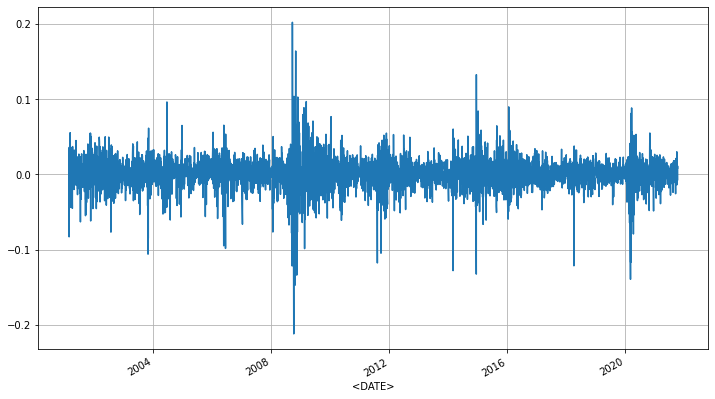

In [95]:
rtsi['log return'].plot(figsize=(12, 7))

plt.grid()
plt.show()

In [96]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

# Setting data & parameters

In [38]:
rescale_factor = 100

In [39]:
start_date = '2010-01-01'

In [40]:
input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor
clusterization_method = 'gaussian'
local_method = 'garch'
local_method_parameters = {'p': 1, 'q': 1, 'mean': 'Zero', 'dist': 'normal'}

In [41]:
n = input_data.shape[0]

In [42]:
n

2965

In [43]:
mu = 0
sigma = .02 * rescale_factor

centers = [mu]  # np.array([[mu] * n])
variances = [sigma ** 2]  # np.array([np.diag([sigma] * n, k=0)])

In [44]:
clusterization_parameters = {'centers': centers, 'variances': variances, 'n_clusters': 1}

## train & test split 

In [45]:
n_train = 2000
n_test = n - n_train

In [46]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:].copy()

In [47]:
# centers_train = centers[:, :n_train].copy()
# cov_matrices_train = cov_matrices[:, :n_train, :n_train].copy()

In [48]:
# clusterization_parameters_train = {'centers': centers_train, 'cov_matrices': cov_matrices_train, 'n_clusters': 1}

## Same data fed to GARCH(1, 1)

In [49]:
model = arch_model(input_data, mean=local_method_parameters['mean'], vol='GARCH', p=p, q=q,
                   dist=local_method_parameters['dist'])

In [50]:
fitted = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 18208.402879687113
Iteration:      2,   Func. Count:     14,   Neg. LLF: 179841745.16303405
Iteration:      3,   Func. Count:     19,   Neg. LLF: 6259.643369009693
Iteration:      4,   Func. Count:     26,   Neg. LLF: 5746.523881004245
Iteration:      5,   Func. Count:     31,   Neg. LLF: 5518.704480234793
Iteration:      6,   Func. Count:     35,   Neg. LLF: 5518.7020679092275
Iteration:      7,   Func. Count:     39,   Neg. LLF: 5518.701967731444
Iteration:      8,   Func. Count:     43,   Neg. LLF: 5518.7019340838815
Iteration:      9,   Func. Count:     46,   Neg. LLF: 5518.701934085554
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5518.7019340838815
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 9


In [51]:
fitted.summary

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:             log return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5518.70
Distribution:                  Normal   AIC:                           11043.4
Method:            Maximum Likelihood   BIC:                           11061.4
                                        No. Observations:                 2965
Date:                Sat, Oct 30 2021   Df Residuals:                     2965
Time:                        18:39:28   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.

In [52]:
fitted.params

omega       0.059160
alpha[1]    0.081849
beta[1]     0.900093
Name: params, dtype: float64

In [53]:
forecast = fitted.forecast(reindex=False, horizon=1)

In [54]:
forecast_variance = forecast.variance.values[0]

In [55]:
forecast_variance

array([1.81711941])

# Testing `FuzzyVolatilityModel` class

In [56]:
logging.basicConfig(level=logging.DEBUG)

In [67]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_method,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=local_method_parameters)

INFO:model.FuzzyVolatilityModel:Creating an instance of FuzzyVolatilityModel


## `fit`

In [68]:
fvm.fit()

DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4043.5895454901565, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4043.5895454901565, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.78705625e-1757]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.16406016]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.164060155844087

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11932.727543850217
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24066663.767517917
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3815.9104011498903
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5215.352095508891
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3957.8020446173223
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3807.8476247138947
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3807.730001725556
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3807.729043605945
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3807.7290429766836
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3807.7290429766836
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


In [69]:
fvm.current_output

1.1640601558440875074

In [70]:
fvm.membership_degrees_current

array([7.78705625e-1757], dtype=float128)

In [71]:
fvm.clusters_parameters_current

{'centers': [0], 'variances': [4.0], 'n_clusters': 1}

## `push`

In [72]:
observation_date = test.index[0]
observation = test.iloc[0]

In [73]:
fvm.push(observation, observation_date)

DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4045.276063319716, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4045.276063319716, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.44187604e-1757]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.15383626]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1538362626947958


Iteration:      1,   Func. Count:      5,   Neg. LLF: 11938.79698400292
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24687153.870436523
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3817.437383590056
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5179.656696955189
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4005.499174151879
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3809.18055778908
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3808.981025987488
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3808.979574857023
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3808.9795734129384
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3808.979573411462
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3808.9795734129384
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


In [74]:
fvm.current_output

1.1538362626947957779

In [79]:
fvm._hist_output

[1.1640601558440875074, 1.1538362626947957779]

## `forecast`

In [81]:
fvm.forecast(test.iloc[1:11])

DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting
DEBUG:pdf:log_pdf = -4046.953476478486, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4046.953476478486, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.69424227e-1758]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.13844229]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.1384422878702163


Iteration:      1,   Func. Count:      5,   Neg. LLF: 11944.836856202703
Iteration:      2,   Func. Count:     13,   Neg. LLF: 189936494.689183
Iteration:      3,   Func. Count:     18,   Neg. LLF: 16743.820486595738
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3819.893392109486
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5016.136776077809
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3815.7387946106073
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3810.197153033996
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3810.196363608463
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3810.1963595954794
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3810.1963595959137
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3810.1963595954794
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4048.5665746737104, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4048.5665746737104, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.36879722e-1759]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.08144541]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0814454072547575
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11950.808593684204
Iteration:      2,   Func. Count:     13,   Neg. LLF: 185662381.9794952
Iteration:      3,   Func. Count:     18,   Neg. LLF: 5062.362953575363
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3818.733941140039
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4994.856624000879
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3815.8339851653404
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3811.183327058603
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3811.1830834606803
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3811.1830820013865
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3811.1830820023006
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3811.1830820013865
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4050.193486246897, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4050.193486246897, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.05515991e-1759]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.03852373]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.0385237315903229
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 11956.785595225587
Iteration:      2,   Func. Count:     13,   Neg. LLF: 182080982.46528172
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4193.328173081277
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3817.1321183002883
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4041.967167662161
Iteration:      6,   Func. Count:     33,   Neg. LLF: 3818.049139557475
Iteration:      7,   Func. Count:     38,   Neg. LLF: 3812.200079016845
Iteration:      8,   Func. Count:     42,   Neg. LLF: 3812.19545158859
Iteration:      9,   Func. Count:     46,   Neg. LLF: 3812.1954450246467
Iteration:     10,   Func. Count:     49,   Neg. LLF: 3812.1954450253543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3812.1954450246467
            Iterations: 10
            Function evaluations: 49
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4051.8081776312056, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4051.8081776312056, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.09926239e-1760]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [0.99104064]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9910406428359273
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11962.759802448603
Iteration:      2,   Func. Count:     13,   Neg. LLF: 177133982.30101582
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3944.5815957434006
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3817.326059273135
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4926.084971875299
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3814.3514546862298
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3813.142596852469
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3813.1425840190054
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3813.142583489662
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3813.142583489662
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4053.4342124596055, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4053.4342124596055, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.12941728e-1761]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [0.95509504]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 0.9550950391382107
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11968.74307007086
Iteration:      2,   Func. Count:     13,   Neg. LLF: 175378893.4091766
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3877.520164888751
Iteration:      4,   Func. Count:     23,   Neg. LLF: 3817.641447901574
Iteration:      5,   Func. Count:     28,   Neg. LLF: 6534.119552744245
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3814.303711815931
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3814.118675961201
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3814.1126197107915
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3814.1126197109866
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3814.1126197107915
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4055.7964628572377, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4055.7964628572377, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.89024057e-1762]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.4187764]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.418776400525191
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 11975.624993687112
Iteration:      2,   Func. Count:     14,   Neg. LLF: 25411590.59644759
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3825.486768218312
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5423.551814097434
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3866.630426066304
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3818.1283809168667
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3818.123499087722
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3818.123488119668
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3818.1234881197724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3818.123488119668
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4058.2507178271358, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4058.2507178271358, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.3427744e-1763]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.89298367]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8929836680543304
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11982.619293829863
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17231660.698059242
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3827.1127290965715
Iteration:      4,   Func. Count:     24,   Neg. LLF: 6315.26828918682
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3821.8600774106726
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3821.681175779466
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3821.584794975642
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3821.5847909015783
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3821.5847909012764
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3821.5847909015783
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4059.8904157467186, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4059.8904157467186, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.48627428e-1764]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.78130527]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7813052675421783
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11988.61938299462
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18056057.088690937
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3828.7611319038497
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5997.988875962443
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3825.2521500471544
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3822.9555755598076
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3822.8807881002317
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3822.8807088666395
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3822.880708865908
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3822.8807088666395
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4061.57398472208, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4061.57398472208, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.20456598e-1764]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.71010756]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7101075612149081
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 11994.673093063426
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18647442.261568148
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3830.407373641846
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5822.84881674375
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3834.106648727806
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3824.2826109564785
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3824.248765654793
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3824.248621010631
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3824.2486210099933
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3824.248621010631
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4063.210896550367, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4063.210896550367, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.34384463e-1765]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.61556711]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6155671063861177
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12000.6698613
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19571755.16894725
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3832.017630158406
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5653.163363511379
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3840.8737246174264
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3825.5026329069024
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3825.493854129598
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3825.4936044109427
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3825.493583958752
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3825.49358395958
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3825.493583958752
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4064.9843971274377, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4064.9843971274377, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.97838954e-1766]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.61964142]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6196414159804065
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12006.825639874802
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19519114.10930615
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3833.661071783973
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5620.802994377162
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3844.0434796447153
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3827.0584514360507
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3827.0523141836966
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3827.052022259751
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3827.051999253922
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3827.0519992551644
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3827.051999253922
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4066.71696236574, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4066.71696236574, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.03499482e-1767]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.59659622]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5965962216413232
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12012.947560130355
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19771194.006409522
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3835.282903986158
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5564.3494588046
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3849.1778051178944
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3828.5124115238673
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3828.509902707268
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3828.5095487313574
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3828.50952857376
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3828.5095285761304
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3828.50952857376
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4068.337227555622, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4068.337227555622, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.39184717e-1767]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.50264191]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5026419092017889
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12018.924182771283
Iteration:      2,   Func. Count:     14,   Neg. LLF: 20937375.772204082
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3836.847273592925
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5453.380252477167
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3861.99268762079
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3829.682719722337
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3829.6826181641045
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3829.6825987260704
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3829.682590369276
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3829.6825903712215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3829.682590369276
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4069.9573916372196, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4069.9573916372196, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.75399553e-1768]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.41767652]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4176765213386702
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12024.894261834108
Iteration:      2,   Func. Count:     14,   Neg. LLF: 22116687.93721524
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3838.3859941535457
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5367.646087273305
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3879.638956573708
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3830.8310376907
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3830.826374641724
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3830.826355391031
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3830.826355391106
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3830.826355391031
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4071.5796912255632, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4071.5796912255632, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.43760269e-1769]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.34209641]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3420964080880364
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12030.879820871889
Iteration:      2,   Func. Count:     14,   Neg. LLF: 23401614.169545293
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3839.9031803009048
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5300.05767828126
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3903.397111570418
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3831.9701801500937
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3831.9483514716276
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3831.948335320845
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3831.948335318184
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3831.948335320845
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4073.356012492289, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4073.356012492289, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.20366806e-1770]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.3738457]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3738457029564135
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12037.047682140408
Iteration:      2,   Func. Count:     14,   Neg. LLF: 23313785.856996644
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3841.455328310593
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5303.037086730879
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3903.5459897457395
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3833.5248883009153
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3833.5038941532202
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3833.503879896721
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3833.503879894065
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3833.503879896721
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4075.021830723432, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4075.021830723432, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.73982386e-1770]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.33059956]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3305995631949117
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12043.07440700709
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24176729.52485968
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3842.998236596633
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5258.562666034602
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3927.099980685837
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3834.786750942035
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3834.7379754061726
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3834.737913323401
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3834.737913322013
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3834.737913323401
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4076.7928078826744, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4076.7928078826744, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.96059958e-1771]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.35983979]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3598397896693433
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12049.236714581766
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24115177.071580313
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3844.54840266566
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5259.4595608109685
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3927.8016637968162
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3836.32628025728
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3836.2773769844266
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3836.2773198078858
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3836.277319806475
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3836.2773198078858
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4078.406784759739, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4078.406784759739, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.89438396e-1772]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.2840586]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.284058602034986
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12055.211034930533
Iteration:      2,   Func. Count:     14,   Neg. LLF: 25539711.67331545
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3846.120985050921
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5197.041418620087
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3982.445555143085
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3837.4954432284867
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3837.3554762131753
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3837.3551648975163
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3837.3551648986045
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3837.3551648975163
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4080.07420797319, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4080.07420797319, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.11246337e-1772]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.24995867]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.2499586706244898
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12061.245802494319
Iteration:      2,   Func. Count:     14,   Neg. LLF: 26342067.783812128
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3847.66943028296
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5163.1592857975975
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4042.1099170879606
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3838.827051305978
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3838.57193879053
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3838.5713229184958
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3838.5713219979207
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3838.5713219979207
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4081.949516780868, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4081.949516780868, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.70549109e-1773]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.35486233]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.354862327043132
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12067.535822992937
Iteration:      2,   Func. Count:     14,   Neg. LLF: 25248193.81988435
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3849.159461398201
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5208.534745356075
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3970.5029474638013
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3840.564604304318
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3840.444166908882
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3840.4439529412284
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3840.4439529420197
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3840.4439529412284
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4084.0066785144018, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4084.0066785144018, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.17989445e-1774]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.56808041]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5680804116302405
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12074.049278406208
Iteration:      2,   Func. Count:     14,   Neg. LLF: 22177692.9610159
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3850.6662592020857
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5338.224963896586
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3900.696155128359
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3842.8398919299793
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3842.8278188274608
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3842.827808186447
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3842.827808186218
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3842.827808186447
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4085.7131086033487, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4085.7131086033487, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.95678355e-1775]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.53253978]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5325397848159756
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12080.132442847334
Iteration:      2,   Func. Count:     14,   Neg. LLF: 22665012.598604616
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3852.34089578484
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5288.103778666586
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3916.397232091491
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3844.239522599333
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3844.212256738947
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3844.2122442423906
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3844.212244239709
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3844.2122442423906
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4087.3254993853975, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4087.3254993853975, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.89023384e-1776]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.43944797]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4394479685958999
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12086.089044974531
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24061401.61000864
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3854.0365832911407
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5207.97581011697
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3956.67050518652
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3845.4374426826844
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3845.345223378874
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3845.34512789386
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3845.3451278938182
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3845.34512789386
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4088.979678779153, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4088.979678779153, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.50899879e-1776]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.38222804]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.382228044173819
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12092.119305244618
Iteration:      2,   Func. Count:     14,   Neg. LLF: 25089632.67294081
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3855.6888389408177
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5159.295236320964
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4008.2263974186785
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3846.7610786601645
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3846.5632633441382
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3846.5629765930307
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3846.562976200868
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3846.562976200868
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4090.6787153733194, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4090.6787153733194, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.75934926e-1777]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.35945282]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.3594528185804644
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12098.184929433406
Iteration:      2,   Func. Count:     14,   Neg. LLF: 25676213.44155943
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3857.304539443344
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5132.694522730837
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4055.8689853446785
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3848.2026938433446
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3847.895771580813
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3847.89530983738
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3847.895308815723
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3847.895308813863
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3847.895308815723
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4092.6050141116193, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4092.6050141116193, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.0199973e-1778]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.48641652]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4864165170643182
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12104.547372114208
Iteration:      2,   Func. Count:     14,   Neg. LLF: 23969848.897093095
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3858.8092480014584
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5185.071054403413
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3975.500758703104
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3850.0214752795523
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3849.892190191651
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3849.89205837976
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3849.892058380703
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3849.89205837976
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4094.27990754396, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4094.27990754396, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.53058624e-1779]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.43808624]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.4380862401134753
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12110.575610473152
Iteration:      2,   Func. Count:     14,   Neg. LLF: 24778142.234502934
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3860.500090244839
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5142.096959981369
Iteration:      5,   Func. Count:     30,   Neg. LLF: 4026.6928599250464
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3851.423896304076
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3851.178358695289
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3851.1780544806925
Iteration:      9,   Func. Count:     48,   Neg. LLF: 3851.1780538894764
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3851.1780538894764
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4096.667039614232, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4096.667039614232, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.92007021e-1780]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.85693314]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8569331439770018
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12117.507162159214
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19109373.548896074
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3861.977484076652
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5388.163574568725
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3891.525275936026
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3854.4319326008613
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3854.4312508433977
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3854.430926909068
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3854.4309086676235
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3854.430908670851
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3854.4309086676235
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4098.35814535357, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4098.35814535357, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.27547694e-1780]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.78366368]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7836636765259766
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12123.572805920508
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19704975.168108877
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3863.732909644985
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5316.1448945217835
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3904.555297921084
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3855.8359397963914
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3855.829412612569
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3855.829363200158
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3855.829363199394
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3855.829363200158
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4100.812579756294, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4100.812579756294, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.09578485e-1781]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.2150133]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2150133015190914
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12130.575590436212
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15523970.76809186
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3865.6097214486067
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5617.122223909017
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3874.5088629874854
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3858.934315989176
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3858.9245555406533
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3858.924218684003
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3858.924188635966
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3858.924188637124
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3858.924188635966
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4102.964489656543, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4102.964489656543, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.27398026e-1782]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.4092436]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4092435984988976
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12137.21051059521
Iteration:      2,   Func. Count:     14,   Neg. LLF: 14230196.045256102
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3867.546231594315
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5769.556886415694
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3872.4140760168657
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3861.240389272425
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3861.2154142860973
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3861.2152040005853
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3861.2152039995526
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3861.2152040005853
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4104.941330893602, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4104.941330893602, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.76453979e-1783]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.46958215]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.469582154395062
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12143.633082724133
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13815309.253483552
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3869.4442823424133
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5802.185326656326
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3873.770658669757
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3863.2081580078516
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3863.179551149772
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3863.179372201461
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3863.179372200546
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3863.179372201461
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4106.915324000104, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4106.915324000104, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.45096519e-1784]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.52215954]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.5221595403637083
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12150.031863753338
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13489166.659148006
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3871.352664592845
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5827.213895537139
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3875.3147966354945
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3865.168073792823
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3865.136665047837
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3865.1365067933466
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3865.1365067925203
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3865.1365067933466
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4108.790515079458, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4108.790515079458, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.75795871e-1785]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.50462456]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.504624557107206
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12156.340353265507
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13487057.317304064
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3873.1971935127303
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5799.277539331468
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3877.519967004566
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3866.9639714248897
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3866.935439605914
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3866.935261489518
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3866.9352614886166
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3866.935261489518
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4110.643996777416, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4110.643996777416, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.88837053e-1786]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.47463426]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4746342555660976
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12162.600711974457
Iteration:      2,   Func. Count:     14,   Neg. LLF: 13542901.74959638
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3875.014277266433
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5768.570143403474
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3879.7628755470137
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3868.724616424419
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3868.698973349418
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3868.6987707641156
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3868.6987707631297
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3868.6987707641156
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4112.256866392774, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4112.256866392774, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.17363961e-1786]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.29081859]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.290818591507175
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12168.5776351365
Iteration:      2,   Func. Count:     14,   Neg. LLF: 14353650.048227847
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3876.595846630674
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5666.45094698892
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3883.2149301581303
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3870.0886891666605
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3870.072025596489
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3870.071713262396
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3870.071713261096
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3870.071713262396
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4113.883214861993, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4113.883214861993, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.30791915e-1787]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.13447917]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1344791733465445
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12174.564974829507
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15185317.199550414
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3878.1044382787404
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5605.820127445832
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3886.4816308103264
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3871.441439466087
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3871.430140830682
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3871.429835173174
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3871.4298080677427
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3871.4298080686895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3871.4298080677427
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4115.520539193728, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4115.520539193728, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.48889729e-1788]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.00076489]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0007648930804325
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12180.565847634307
Iteration:      2,   Func. Count:     14,   Neg. LLF: 16033150.389097232
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3879.5502631469776
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5572.673199946326
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3889.5110279662094
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3872.783235049881
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3872.7754128988017
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3872.7750438799876
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3872.7750122495754
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3872.775012251046
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3872.7750122495754
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4117.670576365366, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4117.670576365366, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.22865984e-1789]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.21083493]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2108349278740747
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12187.198255578536
Iteration:      2,   Func. Count:     14,   Neg. LLF: 14923353.461360766
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3881.7799931159952
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5602.293523446312
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3889.379742118377
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3875.1304173462004
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3875.1163347737047
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3875.1160446032695
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3875.116018674595
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3875.116018675382
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3875.116018674595
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4119.3544183932645, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4119.3544183932645, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.70749304e-1790]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.09979166]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.099791658709237
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12193.25292421761
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15586073.998238467
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3883.3186405549004
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5570.260655059876
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3892.1539640573537
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3876.5723782662208
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3876.5617511758674
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3876.56139950348
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3876.561367642941
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3876.5613676441153
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3876.561367642941
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4121.370817696164, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4121.370817696164, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.29239717e-1790]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.21406577]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.214065772227797
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12199.718792190524
Iteration:      2,   Func. Count:     14,   Neg. LLF: 14960047.237210084
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3885.3120919989897
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5590.111990075482
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3892.9674617561277
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3878.6358753172217
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3878.621709887004
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3878.6214068612226
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3878.6213794322894
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3878.621379433119
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3878.6213794322894
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4123.119601830586, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4123.119601830586, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.24858183e-1791]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.14467383]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.14467382730099
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12205.861731770792
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15429995.744778994
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3886.93121717275
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5571.431786001023
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3895.2912640988616
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3880.1970875738925
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3880.185022367913
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3880.1846826960355
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3880.184651577207
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3880.184651578256
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3880.184651577207
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4125.209134900764, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4125.209134900764, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.7825054e-1792]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.30186569]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3018656898822862
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12212.422920831135
Iteration:      2,   Func. Count:     14,   Neg. LLF: 14577980.9985241
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3889.030560987133
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5599.483179778115
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3895.9554893727986
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3882.3928935803788
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3882.3758607957034
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3882.3754719917865
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3882.3754719902827
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3882.3754719917865
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4126.918495863462, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4126.918495863462, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.03581749e-1793]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.19858559]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1985855861495764
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12218.513612286879
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15170168.270493345
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3890.6160781393573
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5570.965396150137
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3898.4400829111896
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3883.894557464663
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3883.880582102698
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3883.880257099182
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3883.8802271597897
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3883.8802271607065
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3883.8802271597897
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4128.653051974715, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4128.653051974715, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.88713617e-1794]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.12160432]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.121604318883711
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12224.63547425698
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15612112.25895349
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3892.1981088599655
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5557.005087854297
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3900.6321309061386
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3885.428357135243
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3885.4162284119675
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3885.4158735248175
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3885.4158407092696
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3885.4158407103782
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3885.4158407092696
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4130.512687262166, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4130.512687262166, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.38398853e-1794]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.13253868]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1325386814960585
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12230.911722926474
Iteration:      2,   Func. Count:     14,   Neg. LLF: 15663732.345343167
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3893.954566525401
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5559.030113590524
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3902.2260525145543
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3887.1906091219544
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3887.1779677072354
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3887.1776185261424
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3887.1775861864817
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3887.177586187544
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3887.1775861864817
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4132.127583412691, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4132.127583412691, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.75290994e-1795]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.98501757]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9850175712954004
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12236.872990705882
Iteration:      2,   Func. Count:     14,   Neg. LLF: 16654374.35311922
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3895.326484096333
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5541.741092243923
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3904.8014128154555
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3888.4901853482925
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3888.480739593122
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3888.4803474227692
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3888.4803122561343
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3888.4803122575777
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3888.4803122561343
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4133.837039589818, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4133.837039589818, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.98178085e-1796]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.91240421]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9124042100566483
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12242.977517704927
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17281702.28370374
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3896.7963697362675
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5544.112805278497
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3906.7692202022463
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3889.9469204821226
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3889.9386544311474
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3889.9382589850857
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3889.938224685544
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3889.93822468711
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3889.938224685544
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4135.629735867298, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4135.629735867298, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.29519344e-1797]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.90016671]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.900166714980853
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12249.171655169566
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17546102.566361453
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3898.41097495735
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5549.367838748369
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3908.341456924444
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3891.5678304959315
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3891.559524205385
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3891.5591347393492
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3891.5591010206313
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3891.559101022165
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3891.5591010206313
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4137.2460063917715, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4137.2460063917715, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.64774176e-1797]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.77571262]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7757126164558872
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12255.148060967378
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18590652.367034342
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3899.6830303177685
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5554.89196026431
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3910.9476776013744
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3892.8139450598956
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3892.808104289147
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3892.807714613935
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3892.80768429162
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3892.8076842934634
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3892.80768429162
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4138.863292681468, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4138.863292681468, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.26972055e-1798]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.66355108]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6635510802597053
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12261.110903734658
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19711254.607264526
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3900.89365719553
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5575.120075877793
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3913.5444997126797
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3894.029639700372
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3894.025664685878
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3894.0253059070988
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3894.0252816885563
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3894.0252816905736
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3894.0252816885563
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4141.406035249758, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4141.406035249758, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.57164828e-1799]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.1567868]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1567868049913894
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12268.23335248291
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17207414.482213877
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3904.2313568554746
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5512.548826245728
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3909.2765995108757
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3897.4692494292126
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3897.434525572483
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3897.434120497088
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3897.43412049545
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3897.434120497088
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4143.030366447378, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4143.030366447378, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.06726357e-1800]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.0134296]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.013429598035221
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12274.213518141009
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18161143.436700497
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3905.7149705649017
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5471.535626473951
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3912.5522045046687
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3898.782271655775
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3898.760488455231
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3898.759927071424
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3898.7599270695537
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3898.759927071424
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4144.681715117186, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4144.681715117186, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.71855908e-1801]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.90124693]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.901246927551861
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12280.254272594
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19034668.378213435
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3907.163591014211
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5451.682442152522
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3915.6691601038665
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3900.121640982471
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3900.107229011505
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3900.106737233912
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3900.1066875186525
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3900.106687520207
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3900.1066875186525
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4146.429692537915, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4146.429692537915, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.69225159e-1801]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.86147208]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.861472081448058
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12286.366363042853
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19464772.79722762
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3908.720764933634
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5448.874961343521
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3917.92480018804
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3901.645398575364
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3901.633330114027
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3901.632805442532
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3901.632753927753
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3901.6327539296003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3901.632753927753
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4148.215502805862, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4148.215502805862, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.83724857e-1802]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.84962597]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8496259735021778
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12292.580063190819
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19705771.526333425
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3910.3346249142373
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5449.491629209033
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3919.8073909997047
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3903.2475219904672
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3903.236257935409
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3903.2357231291453
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3903.235671446744
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3903.2356714487028
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3903.235671446744
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4149.982930954596, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4149.982930954596, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.84521545e-1803]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.82713352]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8271335205628512
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12298.739815914967
Iteration:      2,   Func. Count:     14,   Neg. LLF: 20089681.233259104
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3911.918022553187
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5448.646755056535
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3921.9244825462038
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3904.8084776367677
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3904.798633558622
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3904.798079441509
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3904.7980277793176
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3904.798027781507
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3904.7980277793176
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4151.692908958976, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4151.692908958976, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.76353009e-1804]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.7700297]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7700296967368263
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12304.801696777893
Iteration:      2,   Func. Count:     14,   Neg. LLF: 20715227.92861124
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3913.4019618586626
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5444.4521647626125
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3924.8156681164146
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3906.24013888674
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3906.2332368758703
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3906.2326458847806
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3906.232597271741
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3906.2325972745293
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3906.232597271741
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4153.310113091844, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4153.310113091844, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.73914684e-1804]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.65895651]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6589565096547096
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12310.814603738341
Iteration:      2,   Func. Count:     14,   Neg. LLF: 21893939.95170369
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3914.70427752679
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5438.9049507747895
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3929.3563602106356
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3907.451964191303
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3907.449060359864
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3907.448478168325
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3907.4484464056677
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3907.448446409464
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3907.4484464056677
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4155.670037181038, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4155.670037181038, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.64223098e-1805]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.03323735]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0332373509658574
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12317.69893592934
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19282980.915521782
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3917.393064921966
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5453.818508321453
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3922.431001327607
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3910.4614028470646
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3910.4229257042625
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3910.422443992669
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3910.422443990844
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3910.422443992669
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4157.420713567199, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4157.420713567199, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.85183994e-1806]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.98261446]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9826144550249976
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12323.840552317528
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19670482.96243042
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3919.025460382719
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5435.274887649479
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3925.052226069299
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3911.998890320311
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3911.9693988340287
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3911.968813050882
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3911.9688130489076
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3911.968813050882
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4159.274826439695, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4159.274826439695, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.46574744e-1807]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.00281174]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.002811738908111
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12330.112637881177
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19531281.245335516
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3920.767594311633
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5436.993777802643
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3926.6421499372163
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3913.7495963959223
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3913.718831640168
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3913.7182586657764
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3913.7182586638155
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3913.7182586657764
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4161.219655551669, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4161.219655551669, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.38653956e-1808]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.07900747]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0790074739213846
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12336.480608181359
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18956115.348771386
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3922.623455353967
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5452.640404312409
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3927.5275717692057
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3915.6897744460766
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3915.649483996577
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3915.6490094248884
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3915.6490094230635
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3915.6490094248884
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4162.836478860714, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4162.836478860714, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.26790924e-1808]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.93867972]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9386797234793818
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12342.495941001693
Iteration:      2,   Func. Count:     14,   Neg. LLF: 19995951.789768916
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3924.1054604488686
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5412.491182427649
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3931.2486331754153
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3916.965961828596
Iteration:      7,   Func. Count:     40,   Neg. LLF: 3916.943554016849
Iteration:      8,   Func. Count:     44,   Neg. LLF: 3916.942848836029
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3916.9428488339163
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3916.942848836029
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4164.639585079448, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4164.639585079448, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.08933983e-1809]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.93047685]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9304768499860747
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12348.684565597276
Iteration:      2,   Func. Count:     14,   Neg. LLF: 20160746.50249989
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3925.770695387385
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5409.622291633616
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3933.200998359899
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3918.6084844165407
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3918.5874731528897
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3918.5869639538423
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3918.586909109946
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3918.5869091113145
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3918.586909109946
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4166.259040076793, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4166.259040076793, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.13703043e-1810]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.80612532]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8061253187820872
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12354.682709783221
Iteration:      2,   Func. Count:     14,   Neg. LLF: 21271288.90740978
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3927.1780946609915
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5387.166650434798
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3937.284511962992
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3919.8614692466167
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3919.8506275701075
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3919.849930507631
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3919.8498626443275
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3919.849862647107
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3919.8498626443275
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4167.880159148055, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4167.880159148055, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.17797254e-1811]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.69455672]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6945567224678568
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12360.672469615376
Iteration:      2,   Func. Count:     14,   Neg. LLF: 22434343.240090773
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3928.521362507601
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5377.17854199911
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3941.769265174446
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3921.0898959773604
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3921.0850817720707
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3921.084308243173
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3921.084255868306
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3921.0842558726267
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3921.084255868306
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4169.6297912903265, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4169.6297912903265, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.4216414e-1811]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.67518055]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.675180552378528
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12366.789942023912
Iteration:      2,   Func. Count:     14,   Neg. LLF: 22895349.541249886
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3930.046051473988
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5379.777172765108
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3944.1366361478727
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3922.5961635314006
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3922.592361884188
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3922.5916023178256
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3922.591556780384
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3922.5915563095405
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3922.5915563095405
            Iterations: 10
            Function evaluations: 51
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4171.474680227957, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4171.474680227957, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.24680291e-1812]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.71844001]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7184400139078522
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12373.076574707211
Iteration:      2,   Func. Count:     14,   Neg. LLF: 22797324.14799048
Iteration:      3,   Func. Count:     19,   Neg. LLF: 3931.743620930272
Iteration:      4,   Func. Count:     24,   Neg. LLF: 5385.295154775019
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3944.5479493576086
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3924.330562519222
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3924.325163060731
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3924.3243965848387
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3924.32434152773
Iteration:     10,   Func. Count:     50,   Neg. LLF: 3924.324341531848
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3924.32434152773
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4191.549462240877, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4191.549462240877, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.29732227e-1821]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [13.30671576]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 13.306715759880081
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12401.730025961797
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2479832.55463916
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1082625477.1800778
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3974.385494000322
Iteration:      5,   Func. Count:     29,   Neg. LLF: 5090.807356978876
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3974.5433197882885
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3967.3715532551378
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3967.3642717889215
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3967.364202952053
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3967.3641960224572
Iteration:     11,   Func. Count:     54,   Neg. LLF: 3967.3641960225887
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3967.3641960224572
            Iterations: 11
            Function evaluations: 54
            Gradient evaluati

DEBUG:pdf:log_pdf = -4193.179921382665, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4193.179921382665, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.41586027e-1822]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [12.0381585]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 12.03815850017827
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12407.516712461776
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2503982.275841862
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1080648305.024085
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3977.0598219024123
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4189.516812332494
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3975.6465990507013
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3969.5923801441413
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3969.5817071525603
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3969.5810039298694
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3969.580935883393
Iteration:     11,   Func. Count:     54,   Neg. LLF: 3969.580935882571
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3969.580935883393
            Iterations: 11
            Function evaluations: 54
            Gradient evaluatio

DEBUG:pdf:log_pdf = -4194.847751279129, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4194.847751279129, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.58770274e-1822]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [10.94278732]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 10.942787315360436
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12413.788839887387
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2555018.2141013187
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1079035504.9334607
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3979.738735337706
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4248.021312328231
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3977.6526256818543
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3971.7748589280727
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3971.762744386928
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3971.761119228725
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3971.760982140317
Iteration:     11,   Func. Count:     55,   Neg. LLF: 3971.7609815985693
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3971.7609815985693
            Iterations: 11
            Function evaluations: 55
            Gradient evaluati

DEBUG:pdf:log_pdf = -4198.230686337938, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4198.230686337938, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.38988087e-1824]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [11.09184675]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 11.091846745728924
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12421.899641788284
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2551984.360536502
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1080940889.2351034
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3982.156491213137
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4201.160983561498
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3980.798976923669
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3974.5337837511183
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3974.524802468918
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3974.52354973864
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3974.523463346015
Iteration:     11,   Func. Count:     54,   Neg. LLF: 3974.523463343622
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3974.523463346015
            Iterations: 11
            Function evaluations: 54
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4200.268793537273, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4200.268793537273, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.02167067e-1825]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [10.34896937]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 10.348969367330108
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12428.428245365743
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2626232.9684163257
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1080398823.7866557
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3984.7008542394715
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4224.9976462025525
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3983.0802754556075
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3976.8086557514503
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3976.8005055395965
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3976.798691918244
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3976.7985870665534
Iteration:     11,   Func. Count:     55,   Neg. LLF: 3976.7985863127797
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3976.7985863127797
            Iterations: 11
            Function evaluations: 55
            Gradient eval

DEBUG:pdf:log_pdf = -4202.271357832655, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4202.271357832655, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.47846112e-1826]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [9.66280723]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 9.662807227995057
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12434.888108295156
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2720244.6646625493
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1079742063.4686606
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3987.2158818523358
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4242.77792666443
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3985.373542630557
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3979.0461429227485
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3979.0389041446024
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3979.036563061296
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3979.0364470133845
Iteration:     11,   Func. Count:     55,   Neg. LLF: 3979.0364458208833
Iteration:     12,   Func. Count:     58,   Neg. LLF: 3979.036445821028
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3979.0364458208833
            Iteratio

DEBUG:pdf:log_pdf = -4205.23824969062, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4205.23824969062, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.877902e-1827]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [9.66037242]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 9.660372421347539
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12442.450690221878
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2725723.533087742
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1080233468.7261982
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3989.6295820544924
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4224.797615942865
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3988.2017521946036
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3981.6579786162015
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3981.6523668467453
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3981.650433143208
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3981.650349243469
Iteration:     11,   Func. Count:     55,   Neg. LLF: 3981.650348347418
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3981.650348347418
            Iterations: 11
            Function evaluations: 55
            Gradient evaluatio

DEBUG:pdf:log_pdf = -4207.906042787008, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4207.906042787008, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.38551896e-1828]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [9.46798686]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 9.467986861043498
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12449.785214455209
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2766629.427437473
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1081223466.2613509
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3992.0605376309813
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4218.190432649398
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3990.86795608825
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3984.146839648148
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3984.142236814928
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3984.1404903492603
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3984.1404219501946
Iteration:     11,   Func. Count:     55,   Neg. LLF: 3984.1404211652207
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3984.1404211652207
            Iterations: 11
            Function evaluations: 55
            Gradient evaluatio

DEBUG:pdf:log_pdf = -4209.518993445241, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4209.518993445241, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.74729471e-1829]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [8.62935185]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 8.629351853580308
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12455.637139631855
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2947028.882645571
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1079782782.4098608
Iteration:      4,   Func. Count:     24,   Neg. LLF: 3994.480824489636
Iteration:      5,   Func. Count:     29,   Neg. LLF: 4239.623312072145
Iteration:      6,   Func. Count:     34,   Neg. LLF: 3992.986874785375
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3986.1889522910533
Iteration:      8,   Func. Count:     43,   Neg. LLF: 3986.185209765004
Iteration:      9,   Func. Count:     47,   Neg. LLF: 3986.1831275142035
Iteration:     10,   Func. Count:     51,   Neg. LLF: 3986.183054647876
Iteration:     11,   Func. Count:     55,   Neg. LLF: 3986.1830535582862
Iteration:     12,   Func. Count:     58,   Neg. LLF: 3986.1830535584077
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3986.1830535582862
            Iteration

DEBUG:pdf:log_pdf = -4211.188467406979, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4211.188467406979, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.27082676e-1829]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [7.91083868]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 7.91083867533546
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218177880.770893
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5033.684527548632
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3996.4830182896153
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4310.275860929045
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3988.421657026061
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3988.2295994998303
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3988.2079758698665
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3988.2057959435833
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3988.2057136948356
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3988.2057136954063
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3988.2057136948356
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4212.801791730096, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4212.801791730096, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.53179478e-1830]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [7.2282439]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 7.228243902353401
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218178512.8879523
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5036.391270609036
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3998.5776096678255
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4312.498644795181
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3990.369793678258
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3990.181417311808
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3990.160997340609
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3990.1590303445887
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3990.1589500152477
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3990.158950015867
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3990.1589500152477
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4214.493461862266, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4214.493461862266, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.6638599e-1831]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [6.65988222]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 6.659882216098679
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218222051.5304708
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5039.460107161729
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4000.6528291270915
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4314.135863740573
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3992.3192951124593
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3992.1323491993016
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3992.112539914531
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3992.1106711105253
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3992.1105915735466
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3992.1105915742673
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3992.1105915735466
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4216.355772031485, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4216.355772031485, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.2436001e-1832]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [6.25046608]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 6.250466075218637
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218366887.3682795
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5042.90700991861
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4002.7649121382083
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4315.661263553357
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3994.335671562985
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3994.1491187320844
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3994.1295853979454
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3994.127754928528
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3994.127675532267
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3994.1276755330805
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3994.127675532267
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4218.0494797419, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4218.0494797419, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.33163914e-1832]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [5.77499181]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.774991805473
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218416231.9423096
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5046.514803368902
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4004.76319396895
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4316.226671468271
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3996.222637094318
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3996.0361394366823
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3996.016753714396
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3996.014929540491
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3996.0148502070315
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3996.0148502079574
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3996.0148502070315
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4220.045258804689, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4220.045258804689, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.80980056e-1833]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [5.53010755]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.530107550166436
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218661474.9119163
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5050.080307306196
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4006.891147572308
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4317.559870882823
Iteration:      5,   Func. Count:     28,   Neg. LLF: 3998.2825404197274
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3998.097220385639
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3998.078091970277
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3998.076300814162
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3998.0762221526657
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3998.0762221536206
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3998.0762221526657
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4221.665791332933, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4221.665791332933, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.57966499e-1834]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [5.07532869]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 5.075328689654388
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218667039.089499
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5054.160786826595
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4008.7824056420513
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4316.950408234643
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4000.0624781584133
Iteration:      6,   Func. Count:     32,   Neg. LLF: 3999.8770417930773
Iteration:      7,   Func. Count:     36,   Neg. LLF: 3999.85783662506
Iteration:      8,   Func. Count:     40,   Neg. LLF: 3999.855998383895
Iteration:      9,   Func. Count:     44,   Neg. LLF: 3999.8559199122465
Iteration:     10,   Func. Count:     47,   Neg. LLF: 3999.855919913241
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3999.8559199122465
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4223.37336505295, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4223.37336505295, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.49011721e-1835]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [4.71552447]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.715524469683952
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218733963.4187164
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5057.8128762748
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4010.679689703054
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4316.151255719047
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4001.86984239508
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4001.6834572185403
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4001.6639275668686
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4001.6619950549766
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4001.6619164679832
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4001.6619164689587
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4001.6619164679832
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4225.273998078632, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4225.273998078632, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.70103575e-1836]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [4.5089394]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.508939404741847
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218947293.5441737
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5061.238248219029
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4012.681239364858
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4316.291596157827
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4003.8065736209373
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4003.6221982190114
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4003.6028825682197
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4003.600962905882
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4003.6008858169403
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4003.600885817854
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4003.6008858169403
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4226.953887585421, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4226.953887585421, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.80822039e-1836]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [4.18294061]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.182940613713254
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1218999204.5055313
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5065.299503437651
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4014.500708833867
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4314.73768172627
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4005.5380802390932
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4005.3541731625537
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4005.334590029192
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4005.332570434104
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4005.332494441776
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4005.332494442605
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4005.332494441776
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4228.892752563702, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4228.892752563702, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.60143513e-1837]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [4.04974277]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.049742769096289
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1219263626.4847236
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5068.590812336104
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4016.497865307546
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4315.0133619707885
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4007.4802033937112
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4007.3003747782923
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4007.2813372213927
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4007.279394958802
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4007.2793216007703
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4007.279321601526
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4007.2793216007703
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4230.554362838183, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4230.554362838183, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.93838367e-1838]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.75386194]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.753861943905462
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1219304861.9819255
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5072.793968237753
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4018.2493616046145
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4312.912182501928
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4009.1447456086385
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4008.967140388537
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4008.947979645754
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4008.9459550299807
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4008.945883917554
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4008.9458839182844
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4008.945883917554
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4232.296734197936, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4232.296734197936, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.64734051e-1839]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.53599629]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.535996288628171
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12535.768325184008
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4374.995027473452
Iteration:      3,   Func. Count:     21,   Neg. LLF: 6061.790621350247
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4096.456469041907
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4014.154727385474
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4680.253537295561
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4010.667254574538
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4010.664719873116
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4010.6645873969837
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4010.664583270499
Iteration:     11,   Func. Count:     56,   Neg. LLF: 4010.664583271606
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4010.664583270499
            Iterations: 11
            Function evaluations: 56
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4235.213408060769, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4235.213408060769, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.67936795e-1840]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [4.08473333]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 4.084733332961199
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1220625043.5256515
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5074.181370597304
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4022.9741740137415
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4322.226505826575
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4013.8674828836265
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4013.704568023455
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4013.688664058009
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4013.6872749156437
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4013.687212372836
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4013.6872123734593
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4013.687212372836
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4237.008247257627, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4237.008247257627, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.77496491e-1841]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.87319906]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.873199061909082
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1220780716.5237904
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5077.814798606535
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4024.8520458807616
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4322.100436474486
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4015.664074361714
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4015.5053427811226
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4015.48993881587
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4015.4886032862614
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4015.4885436316335
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4015.4885436321574
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4015.4885436316335
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4238.6844212972555, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4238.6844212972555, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.45460575e-1841]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.6071583]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.6071582958157005
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1220837657.7572596
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5081.224516007138
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4026.604686806603
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4320.87229052338
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4017.321599213842
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4017.1667532256624
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4017.1516897707156
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4017.1503738471292
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4017.1503169594916
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4017.150316959921
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4017.1503169594916
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4240.795986112272, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4240.795986112272, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.76077699e-1842]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.63804732]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.6380473243144493
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1221306391.9938726
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5083.662523882168
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4028.7289298685046
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4323.4529226150535
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4019.4340099147803
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4019.2806665500602
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4019.2659041741526
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4019.26463954294
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4019.2645835564713
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4019.264583556899
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4019.2645835564713
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4242.516113951359, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4242.516113951359, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.15255248e-1843]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.42173372]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.4217337243393398
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1221408161.365744
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5087.106875394234
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4030.4915025135715
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4322.726904886876
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4021.1133354574813
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4020.963497449334
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4020.949039787493
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4020.9477942559083
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4020.947740658965
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4020.9477406593446
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4020.947740658965
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4244.1874037189245, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4244.1874037189245, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.92693824e-1844]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.19462798]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.194627976631423
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1221466724.5353942
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5090.329467876834
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4032.1751908530464
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4321.407652048187
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4022.713126397828
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4022.5661812078642
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4022.551849537489
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4022.5505920833575
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4022.5505404757723
Iteration:     10,   Func. Count:     47,   Neg. LLF: 4022.550540476184
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4022.5505404757723
            Iterations: 10
            Function evaluations: 47
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4245.864181489595, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4245.864181489595, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.10819215e-1844]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.99151353]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.9915135319368913
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12580.530898142004
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4387.981208570062
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5694.1406425555
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4111.247956940652
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4025.101344467094
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4052.457510430324
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4024.132525432443
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4024.130768301926
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4024.130759969989
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4024.130759965895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4024.130759969989
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4247.789550718953, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4247.789550718953, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.6159869e-1845]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.96470456]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.964704555452279
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12586.834536268765
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4389.771432851008
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5674.33756183428
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4113.198992619988
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4026.9779929145866
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4054.8434332910656
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4026.018151526899
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4026.016476556979
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4026.0164686754024
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4026.0164686713906
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4026.0164686754024
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4249.492055242641, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4249.492055242641, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.94475736e-1846]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.79986504]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.799865036250875
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12592.95669351311
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4391.681307337218
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5557.812432890447
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4115.0313889003855
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4028.5977649416836
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4070.5860069858018
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4027.601835426519
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4027.600442411779
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4027.6004356384487
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4027.6004356346816
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4027.6004356384487
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4251.765322234553, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4251.765322234553, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.0323701e-1847]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.01135784]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.0113578444784532
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12599.762955110844
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4393.149655165413
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5735.97031727662
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4117.123163625741
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4030.8900426074415
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4046.820536150347
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4029.980024721799
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4029.9781915057365
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4029.9781834939718
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4029.978183489896
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4029.9781834939718
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4253.37846548545, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4253.37846548545, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.04230987e-1848]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.78803933]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.7880393333831095
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12605.789965305345
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4395.03655694374
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5588.567658567552
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4118.968084643146
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4032.2803433973613
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4045.6697001476577
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4031.4507186194564
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4031.4493132209186
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4031.4493075569603
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4031.449307553286
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4031.4493075569603
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4255.0030141827265, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4255.0030141827265, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.19033844e-1848]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.59211231]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.592112313672364
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12611.795469062801
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4396.982004855183
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5463.2568362999755
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4120.721090691885
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4033.683518013326
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4048.8234239446056
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4032.899375422924
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4032.8983306073746
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4032.8983265589436
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4032.8983265556976
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4032.8983265589436
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4256.621872236403, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4256.621872236403, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.35835587e-1849]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.41033684]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4103368447746494
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12617.79406429705
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4398.989263756961
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5351.065287064118
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4122.375661381694
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4035.0597320498614
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4052.4692049882096
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4034.30415191384
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4034.3033834864596
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4034.3033806312137
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4034.3033806284116
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4034.3033806312137
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4258.374474885556, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4258.374474885556, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.08755566e-1850]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.33048301]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3304830080130827
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12623.936597657204
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4400.843388630992
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5302.044736054586
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4124.057734285569
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4036.6483843651113
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4055.53386548471
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4035.895855325539
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4035.8952006415575
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4035.895198250836
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4035.8951982482613
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4035.895198250836
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4260.047020744731, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4260.047020744731, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.67513887e-1851]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.20735466]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2073546600622462
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12630.00055983708
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4402.827446331034
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5230.584465231923
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4125.625341805102
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4038.0584256089687
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4055.076549085263
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4037.340751729999
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4037.340538572419
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4037.3405268626893
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4037.340526860544
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4037.3405268626893
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4261.659106828181, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4261.659106828181, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.53096814e-1851]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.05694409]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0569440911126664
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12635.972360424123
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4404.953014256672
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5147.807658421594
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4127.037769518562
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4039.306582921771
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4052.074536738663
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4038.6548152186983
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4038.654650254577
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4038.6546441394466
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4038.6546441376922
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4038.6546441394466
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4263.272976055066, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4263.272976055066, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.04839789e-1852]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.92138481]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9213848131279296
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12641.92916683603
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4407.133988427233
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5075.139601869513
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4128.327858984501
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4040.5170835878466
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4049.3705992920673
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4039.9369862329722
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4039.9368532473236
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4039.9368508437547
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4039.936850842396
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4039.9368508437547
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4265.101142975957, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4265.101142975957, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.89901587e-1853]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.93816091]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9381609105687152
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12648.257863325607
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4408.6327460818375
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5086.546510383192
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4129.96172634538
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4042.2498714926364
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4052.4663089364362
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4041.632286975464
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4041.6321510109765
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4041.632148459489
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4041.6321484580444
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4041.632148459489
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4266.7576233652335, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4266.7576233652335, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.34778153e-1854]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.84239067]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8423906679750317
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12654.212896200836
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4410.68776716749
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5038.713876815824
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4131.241958855715
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4043.502029122229
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4050.292610476357
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4042.973214971321
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4042.9731022989395
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4042.973101470606
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4042.973101470606
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4268.391973639954, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4268.391973639954, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.8235566e-1854]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.74135788]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7413578769732097
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12660.291565004683
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4412.825855443385
Iteration:      3,   Func. Count:     21,   Neg. LLF: 4990.209813892217
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4132.371301122612
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4044.6777256848245
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4048.7839091653836
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4044.2453866419355
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4044.2452974954613
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4044.2452974971247
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4044.2452974954613
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4270.04246425565, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4270.04246425565, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.500421e-1855]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.66046452]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6604645232601911
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12666.308921995675
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4414.929088582197
Iteration:      3,   Func. Count:     21,   Neg. LLF: 4952.041583620616
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4133.439024852776
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4045.886623998387
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4048.4540245715143
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4045.529310805066
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4045.529240365372
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4045.5292403658386
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4045.529240365372
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4272.403457358321, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4272.403457358321, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.30182465e-1856]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.04845309]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.048453087348353
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12673.261671560875
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4414.205308628184
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5215.092015389269
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4136.654132859689
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4049.7169215246995
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4083.101956379821
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4048.5004611586064
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4048.500157309941
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4048.5001507299653
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4048.500150726929
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4048.5001507299653
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4274.05319698751, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4274.05319698751, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.34280248e-1857]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.94062046]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9406204594120446
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12679.200427356216
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4416.15828320653
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5167.88792371602
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4138.086130867468
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4050.711848118539
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4070.8234283692605
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4049.851188157305
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4049.851002654268
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4049.8509982098376
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4049.850998207724
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4049.8509982098376
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4275.665282701275, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4275.665282701275, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.26520604e-1857]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.81910671]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8191067062996298
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12685.220666465397
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4418.193476641302
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5115.713655461365
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4139.344204527253
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4051.6881835665663
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4061.403780912852
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4051.1012935816893
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4051.1011757201622
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4051.1011734043013
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4051.1011734030344
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4051.1011734043013
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4277.326332918952, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4277.326332918952, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.40312474e-1858]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.74008873]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.740088726548807
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12691.344905638382
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4420.184269654267
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5079.385450943208
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4140.592543387147
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4052.8828930626664
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4058.2605846413835
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4052.4268403833275
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4052.4267455239938
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4052.426744389168
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4052.426744388339
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4052.426744389168
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4278.967797986068, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4278.967797986068, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.65475785e-1859]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.65600732]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6560073209793194
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12697.271940519995
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4422.231688844086
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5041.777798795691
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4141.693928083645
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4054.0396289587225
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4056.5665829079235
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4053.689984177
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4053.6899059116604
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4053.689905913079
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4053.6899059116604
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4280.621469328213, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4280.621469328213, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.90669856e-1860]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.58770727]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.587707273652631
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12703.402259789902
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4424.267166548335
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5010.737124135092
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4142.734306613997
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4055.2422556494744
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4056.3854145984596
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4054.9612970310086
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4054.9612311059213
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4054.9612311062056
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4054.9612311059213
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4282.795166810058, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4282.795166810058, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.01319242e-1860]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.85896282]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8589628154869218
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12710.079208684932
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4424.78265542681
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5150.648979802951
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4145.7659825625315
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4058.2662932389567
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4073.2511324987286
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4057.524790739393
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4057.524646929076
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4057.524644164482
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4057.524644162845
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4057.524644164482
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4284.681037225291, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4284.681037225291, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.53698213e-1861]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.91876106]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9187610554552232
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12716.421375790644
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4426.470127431765
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5165.911576860673
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4147.591908682985
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4060.2098149262315
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4079.1492753148214
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4059.34287682482
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4059.342701381729
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4059.3426982342535
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4059.342698232311
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4059.3426982342535
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4286.307373800525, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4286.307373800525, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.02245482e-1862]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.80900714]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8090071392228726
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12722.288325308953
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4428.4213197735435
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5131.931834659227
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4148.879005020646
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4061.1810069698836
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4070.4712256883427
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4060.617167051797
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4060.61705977661
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4060.6170575978567
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4060.6170575967167
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4060.6170575978567
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4288.4253179154775, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4288.4253179154775, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.63536796e-1863]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.02003215]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.020032148316326
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12729.029438928004
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4429.779514452848
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5200.609950091657
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4151.253013963068
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4064.0835161332016
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4091.971431731019
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4062.9508822788043
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4062.9506329589894
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4062.9506288419034
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4062.950628839398
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4062.9506288419034
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4290.108687059266, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4290.108687059266, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.75259099e-1864]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.93644852]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9364485203878186
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12735.062870957754
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4431.664337331132
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5177.392773198164
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4152.741928368216
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4065.166494218879
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4084.011842433878
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4064.3623729759356
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4064.3622176834965
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4064.3622139723684
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4064.362213970541
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4064.3622139723684
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4291.934498025679, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4291.934498025679, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.08775432e-1864]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.95065233]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9506523280589165
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12741.332629154413
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4433.456022737732
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5177.205000639829
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4154.446239980693
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4066.844570842084
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4085.362701464981
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4066.053212830309
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4066.053061516933
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4066.0530578482267
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4066.053057846441
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4066.0530578482267
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4293.5731879755485, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4293.5731879755485, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.11279234e-1865]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.84569334]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8456933441691585
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12747.40138986842
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4435.383134386311
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5149.707280959554
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4155.799040389723
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4067.8967660706253
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4076.505500799765
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4067.3606377790284
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4067.36052977733
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4067.3605270505054
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4067.3605270494136
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4067.3605270505054
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4295.2293189691245, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4295.2293189691245, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.03281466e-1866]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.76184939]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7618493943029474
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12753.330460734462
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4437.32487992799
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5125.202546482216
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4157.090138879757
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4069.0843086719296
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4072.5000498399136
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4068.681356631978
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4068.681248544778
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4068.681246933603
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4068.681246932795
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4068.681246933603
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4296.9674767899505, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4296.9674767899505, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.09146416e-1867]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.73781625]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.737816253880464
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12759.594690289116
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4439.170429861566
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5115.739948517956
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4158.541295365418
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4070.534705908945
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4072.667811019148
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4070.169673437299
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4070.169562393212
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4070.169561377986
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4070.1695613772777
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4070.169561377986
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4298.579645567659, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4298.579645567659, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.41442495e-1867]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.63648936]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6364893643013747
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12765.586995119302
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4441.198730291128
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5086.00801411135
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4159.56967779519
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4071.6550095156463
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4071.695031967026
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4071.3649970978604
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4071.36481675604
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4071.3648167566917
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4071.36481675604
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4301.002901272164, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4301.002901272164, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.25364141e-1868]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.05679]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0567900019372436
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12772.57651756358
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4441.6593259285
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5255.6230688012365
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4163.162564620201
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4075.5562038573803
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4111.723186662141
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4074.510841514838
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4074.5106198039925
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4074.5106134654216
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4074.5106134627954
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4074.5106134654216
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4302.620864579589, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4302.620864579589, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.48599809e-1869]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.9285875]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.928587495102291
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12778.576428301276
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4443.544668513921
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5227.505716019528
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4164.618116757685
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4076.436944932144
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4090.709582388349
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4075.8015461288255
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4075.801416534691
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4075.8014114299385
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4075.801411428519
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4075.8014114299385
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4304.249556558016, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4304.249556558016, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.87718077e-1870]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.81974619]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8197461917266173
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12784.568097353318
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4445.473180397575
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5199.473363160954
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4165.9764203195955
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4077.5267453651654
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4081.078981081408
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4077.0832256804547
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4077.0830635113584
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4077.0830596701244
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4077.0830596689048
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4077.0830596701244
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4305.86164568927, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4305.86164568927, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.72853483e-1871]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.71106394]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7110639357708013
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12790.41789551299
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4447.459234412772
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5168.371900600758
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4167.1785695353265
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4078.657421680222
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4078.5757728888157
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4078.3017222338767
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4078.301196179051
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4078.3011961811003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4078.301196179051
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4308.014150327461, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4308.014150327461, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.13038543e-1871]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.95211349]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.952113486281823
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12797.116944837144
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4448.652481023644
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5251.056275415265
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4169.728075507575
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4081.353895426065
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4093.7144470075923
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4080.751748411368
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4080.751610585209
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4080.751604478023
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4080.751604476636
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4080.751604478023
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4309.62928075115, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4309.62928075115, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.24793796e-1872]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.83253998]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8325399825700832
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12803.208792071979
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4450.574817947744
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5222.08641591841
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4171.100214062293
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4082.4363744148986
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4084.0841185938334
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4082.011327633104
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4082.0110906881678
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4082.0110876049184
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4082.0110876034237
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4082.0110876049184
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4311.587830466933, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4311.587830466933, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.17100544e-1873]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.93973683]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9397368295683184
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12809.656427893922
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4452.211245643744
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5248.506649621861
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4173.069674960768
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4084.5084066984887
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4091.3848827847805
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4083.9892504541012
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4083.989087958058
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4083.989081475364
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4083.9890814740083
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4083.989081475364
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4313.274463632603, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4313.274463632603, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.87085711e-1874]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.86613113]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8661311329004664
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12815.630025324837
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4454.0975372129
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5229.369146225119
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4174.554339518434
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4085.8172902572696
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4087.1341269351756
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4085.3932174204006
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4085.39295209499
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4085.392949292523
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4085.3929492909615
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4085.392949292523
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4315.112556332909, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4315.112556332909, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.34174468e-1875]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.89451347]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.894513469708605
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12821.998051236335
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4455.866027959739
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5233.399832083721
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4176.285577733036
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4087.53897438138
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4089.150124996716
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4087.1085163437037
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4087.1082644987173
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4087.108261167091
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4087.1082611655224
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4087.108261167091
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4316.794884231569, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4316.794884231569, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.73700981e-1875]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.82265645]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8226564493704798
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12828.09309114184
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4457.762271742704
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5214.399124799314
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4177.72605034003
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4088.8826426834394
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4088.5559858770607
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4088.500900974358
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4088.4949114546944
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4088.494911457091
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4088.4949114546944
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4318.532304981931, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4318.532304981931, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.05668035e-1876]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.79220229]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7922022885965254
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12834.240998455733
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4459.613714663699
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5204.2288107344475
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4179.234502211491
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4090.3698022556455
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4090.0877295832775
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4089.9916731832673
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4089.9890202405268
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4089.9890202424986
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4089.9890202405268
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4320.21192387532, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4320.21192387532, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.69902823e-1877]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.72845305]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7284530464411958
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12840.317767625525
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4461.527836640896
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5185.791478704647
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4180.5792366180885
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4091.738502563309
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4092.7401884447117
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4091.3505335920677
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4091.3503205097168
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4091.3503194238915
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4091.3503194233003
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4091.3503194238915
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4322.042318510294, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4322.042318510294, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.13840747e-1878]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.76532236]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7653223634707924
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12846.516619438156
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4463.242160669692
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5194.068814113871
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4182.304803786506
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4093.432703193377
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4093.966413736627
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4093.048353545443
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4093.048084348671
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4093.048083583022
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4093.048083583022
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4324.045184640612, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4324.045184640612, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.23320935e-1878]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.90658161]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.906581610695387
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12853.015935368356
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4464.77793451752
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5229.880301432373
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4184.457901872327
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4095.5331627364585
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4095.3564060923663
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4095.137707079055
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4095.136541312541
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4095.1365406824993
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4095.1365406824993
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4326.0570593513075, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4326.0570593513075, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.64926607e-1879]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.03971106]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.039711061152462
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12859.48155423726
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4466.464008994228
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5254.906067187464
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4186.503933278245
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4097.683870933929
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4101.200139606495
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4097.21702000966
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4097.216815349324
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4097.216809621155
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4097.2168096196665
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4097.216809621155
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4327.765716758585, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4327.765716758585, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.98696574e-1880]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.9698649]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9698649035247748
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12865.656742855806
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4468.32500795335
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5240.643479903978
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4188.0764544560025
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4099.088837670555
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4099.092103825083
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4098.682148303724
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4098.681467250605
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4098.68146651622
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4098.68146651622
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4329.611054125917, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4329.611054125917, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.71857004e-1881]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.99242046]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.992420458976654
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12871.938807795661
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4470.127845931366
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5242.106208564719
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4189.830542918232
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4100.820675414212
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4100.80011057977
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4100.413752977819
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4100.413027912626
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4100.413027189682
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4100.413027189682
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4331.409738068402, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4331.409738068402, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.81001548e-1882]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.98361044]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9836104369542402
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12878.145711693376
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4471.955595774158
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5237.943266515305
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4191.514182257035
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4102.4515432079625
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4102.092079604259
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4102.064699209042
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4102.051247518965
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4102.051247521595
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4102.051247518965
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4333.0260853451355, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4333.0260853451355, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.55124785e-1882]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.86162277]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.861622770751138
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12884.120670729684
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4473.866399377566
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5214.315795429778
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4192.892504721714
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4103.742998392234
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4105.754393579699
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4103.321277453333
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4103.321071965358
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4103.321069569197
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4103.32106956857
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4103.321069569197
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4334.686079103895, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4334.686079103895, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.94954524e-1883]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.77887601]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.778876009497925
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12890.21674675665
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4475.787247854274
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5194.670346425929
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4194.235953401278
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4105.123725863998
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4110.9016444391455
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4104.653721864076
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4104.653574360453
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4104.653571870407
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4104.653571870119
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4104.653571870407
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4336.3063864624655, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4336.3063864624655, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.83531786e-1884]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.67933055]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.679330550027616
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12896.128054755365
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4477.776240180339
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5169.359221333212
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4195.378203317618
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4106.417447025579
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4112.759103266007
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4105.878988562552
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4105.878832763151
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4105.878832763186
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4105.878832763151
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4338.0249678366845, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4338.0249678366845, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.04639128e-1884]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.65072847]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6507284734089929
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 12902.330844257904
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4479.640379246378
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5159.97138614249
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4196.73329006657
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4107.867087223877
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4114.388561901187
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4107.310736570335
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4107.310580053567
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4107.310580054073
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4107.310580053567
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4339.740831948978, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4339.740831948978, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.88149814e-1885]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.62313171]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6231317128911322
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12908.393927331395
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4481.507265043206
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5150.790440986847
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4198.058105610003
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4109.306238836074
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4116.010104134769
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4108.73170339478
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4108.731545543602
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4108.731545544425
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4108.731545543602
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4341.507433707318, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4341.507433707318, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.21572128e-1886]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.62995158]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6299515755621978
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12914.656110733971
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4483.2823395062505
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5151.3435284067
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4199.57355759174
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4110.845952047147
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4117.5568821751085
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4110.273589727497
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4110.273434144194
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4110.273434144971
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4110.273434144194
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4343.465114734794, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4343.465114734794, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.54013045e-1887]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.75575642]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7557564206295444
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12921.078484027395
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4484.746513194739
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5186.006964276703
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4201.838872773731
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4112.78008084418
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4118.843485418115
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4112.284802197599
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4112.28465913563
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4112.284657971352
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4112.284657971078
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4112.284657971352
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4345.09344088613, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4345.09344088613, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.91036037e-1888]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.66320902]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6632090178077248
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12927.093420665275
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4486.698327159858
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5165.2782659213235
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4202.952548153975
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4114.124864928792
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4120.934254168503
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4113.522060355438
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4113.521888148568
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4113.521888149889
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4113.521888148568
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4346.74615925931, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4346.74615925931, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.70658844e-1888]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.59473833]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5947383267250606
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12933.138615275278
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4488.650843514
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5147.561527287651
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4204.03021487409
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4115.475654360143
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4122.846970381309
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4114.792984443137
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4114.792784260395
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4114.792784262572
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4114.792784260395
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4348.428862184572, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4348.428862184572, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.17205132e-1889]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.55154039]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.5515403943697668
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12939.220977836136
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4490.569848550353
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5134.964887460046
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4205.155653222352
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4116.851253498758
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4124.57090541299
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4116.122321865176
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4116.122104366345
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4116.12210436889
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4116.122104366345
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4351.130950937259, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4351.130950937259, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.12734521e-1890]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.15031622]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1503162169867407
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12946.566079385673
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4490.55253939881
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5377.1622416339005
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4210.231876645175
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4120.585917256795
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4121.824776689011
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4120.066076323603
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4120.065416992825
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4120.065415962913
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4120.065415960991
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4120.065415962913
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4353.019792709655, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4353.019792709655, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.21754338e-1891]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.18204866]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1820486640412162
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12952.904331594658
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4492.4309362795875
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5376.357701770528
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4212.04960398649
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4122.400140297946
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4123.568789028477
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4121.882647752183
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4121.881981875054
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4121.8819808576745
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4121.881980855766
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4121.8819808576745
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4356.390767051708, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4356.390767051708, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.10542391e-1892]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.14956479]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.1495647948291925
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12961.076535105345
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4494.565780117129
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5533.037352422223
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4214.821609195009
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4133.625406089217
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4170.742535817801
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4126.410985070539
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4126.407885132295
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4126.40785143116
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4126.407850598195
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4126.407850598195
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4358.011790529346, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4358.011790529346, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.18538171e-1893]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.91072837]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.910728373275937
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12966.99517210578
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4496.221164694145
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5518.091614623445
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4216.837729393589
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4132.113667136311
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4273.2953534308035
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4127.912320701566
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4127.911234699949
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4127.911223716899
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4127.911223712053
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4127.911223716899
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4360.139318621025, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4360.139318621025, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.60347609e-1894]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.01927923]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.019279233880229
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12973.718584461893
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4498.423331332097
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5517.58725323651
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4218.816684017975
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4134.896610470888
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4232.268194421213
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4130.074031610886
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4130.072635400928
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4130.072624666134
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4130.0726246623135
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4130.072624666134
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4362.506670136581, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4362.506670136581, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.44020265e-1895]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.2703541]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.270354095472978
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12980.564471135443
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4500.882211522289
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5526.295365470955
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4220.827566369888
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4139.478355127467
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4176.704201040942
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4132.547197859405
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4132.544290887177
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4132.544260287617
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4132.544259513802
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4132.544259513802
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4364.259826797924, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4364.259826797924, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.22707185e-1896]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.10467383]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.104673827418077
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12986.821456418422
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4502.706535769794
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5510.619309913865
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4222.872213183884
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4139.237208151244
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4218.345367858871
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4134.229563317753
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4134.228015657362
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4134.228003882235
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4134.228003878801
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4134.228003882235
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4366.083011292436, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4366.083011292436, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.82716917e-1897]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.00065926]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.000659257627494
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12992.938390888645
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4504.610859253125
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5496.618148144597
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4224.888110472985
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4139.992280084197
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4257.807521320625
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4135.986349453988
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4135.98530677386
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4135.98529726684
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4135.985297262438
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4135.98529726684
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4367.872041324435, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4367.872041324435, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.14097149e-1897]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.88590057]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.8859005685513246
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 12999.28360574925
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4506.4844228264665
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5480.20430748434
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4226.8845784551495
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4140.861999717694
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4300.215641844448
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4137.690264154035
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4137.6894636594125
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4137.689449925504
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4137.689449385646
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4137.689449385646
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4369.534434952548, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4369.534434952548, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.16424496e-1898]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.70341036]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.7034103573143797
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13005.312936713013
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4508.27314134859
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5453.850533726439
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4228.854392548655
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4141.478782320892
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4323.317489182758
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4139.208592072674
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4139.207886690536
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4139.2078706871725
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4139.207869926178
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4139.207869926178
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4371.196828580661, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4371.196828580661, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.10523511e-1899]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.53957756]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.539577559634813
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13011.3699454737
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4510.096201478174
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5424.790913377992
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4230.769211289571
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4142.409101316634
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4282.028687621062
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4140.698997573381
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4140.698395266486
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4140.69838162029
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4140.698380921365
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4140.698380921365
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4373.321193075402, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4373.321193075402, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.90612102e-1900]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.68056372]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.680563718331448
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13018.034015389014
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4511.968537717481
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5451.953133759736
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4232.698523641235
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4144.940055940286
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4326.646403212799
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4142.89085806478
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4142.890157577806
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4142.890142088353
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4142.8901412698215
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4142.8901412698215
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4375.404588477778, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4375.404588477778, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.1084515e-1901]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.78230139]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.7823013876304126
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13024.610811593531
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4513.93308242779
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5467.142033408892
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4234.640683848913
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4147.336643661603
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4345.0036752739525
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4145.006121998327
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4145.005384592192
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4145.0053679757875
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4145.005367157679
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4145.005367157679
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4377.435753183558, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4377.435753183558, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.01322812e-1902]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.84142774]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.8414277363063056
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13031.1477106416
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4515.922582817815
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5473.0621605495135
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4236.597434976236
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4149.512466042557
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4346.921213545729
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4147.039193377184
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4147.038447925213
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4147.038431054014
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4147.038430268248
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4147.038430268248
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4379.084432719499, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4379.084432719499, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.54097319e-1902]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.6553205]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.655320497459455
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13037.164363831816
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4517.716171696549
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5440.91028039589
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4238.5556962967585
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4150.296988293437
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4307.619928578801
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4148.531550597884
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4148.530906004445
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4148.530892090671
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4148.53089131452
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4148.53089131452
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4380.744910419672, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4380.744910419672, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.92859137e-1903]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.49536022]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4953602230159206
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13043.250204512842
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4519.552409947594
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5407.869917928669
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4240.451563020968
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4151.3672167763425
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4249.048499390099
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4150.011390605756
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4150.010921004891
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4150.010909480978
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4150.010908958993
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4150.010908958993
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4382.452853427447, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4382.452853427447, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.30772673e-1904]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.38077497]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.38077497483701
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13049.312032891354
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4521.415778867268
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5380.003292471089
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4242.2914533138455
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4152.687784843343
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4217.697296123868
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4151.541023248259
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4151.540673785876
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4151.540663110537
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4151.540663106882
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4151.540663110537
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4384.363095259417, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4384.363095259417, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.85780177e-1905]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.40343411]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4034341077989887
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13055.73596028774
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4523.209452276902
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5384.238122593888
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4244.150598547556
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4154.569128268837
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4223.125321270274
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4153.394629823052
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4153.394265139489
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4153.3942542775185
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4153.39425427375
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4153.3942542775185
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4386.028340539658, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4386.028340539658, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.48625809e-1905]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.27137276]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2713727592062405
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13061.708490314551
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4525.089935243248
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5350.431382736624
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4245.929291563962
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4155.804036507014
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4196.760479594632
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4154.840314144136
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4154.840055444667
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4154.8400452259575
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4154.840045223081
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4154.8400452259575
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4387.649878280166, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4387.649878280166, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.93676597e-1906]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.12497235]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1249723456829557
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13067.811381354672
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4527.0255158881055
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5309.439876900723
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4247.606491945392
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4156.981239512473
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4180.166017883826
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4156.185932698989
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4156.185725272078
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4156.185715689079
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4156.185715686906
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4156.185715689079
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4389.453974175785, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4389.453974175785, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.83459888e-1907]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.10649177]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1064917654613686
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13074.048558336613
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4528.803557830017
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5302.5357215067015
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4249.336575691468
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4158.628288444803
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4180.598135555073
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4157.8431740540245
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4157.842969171023
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4157.8429599075735
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4157.842959905445
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4157.8429599075735
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4391.2998997822, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4391.2998997822, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.63282214e-1908]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.11588441]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.115884412517855
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13080.337793250785
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4530.536081135378
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5304.306453413799
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4251.095729996185
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4160.378021327633
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4183.323847864534
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4159.57866226763
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4159.578455173003
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4159.578445976855
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4159.578445974679
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4159.578445976855
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4392.9287134133665, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4392.9287134133665, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.49727085e-1908]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.98904217]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9890421745586524
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13086.248809528654
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4532.4946796589165
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5266.065208387667
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4252.64604906608
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4161.55767526803
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4173.951551578005
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4160.903833221917
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4160.903641593909
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4160.903633861933
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4160.903633860194
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4160.903633861933
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4394.597476617218, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4394.597476617218, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.8220566e-1909]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.89928618]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8992861774340646
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13092.427291834367
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4534.439388991748
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5235.830427554103
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4254.137853270525
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4162.8537444938975
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4170.794495358448
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4162.280478846632
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4162.280290923904
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4162.280285124403
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4162.2802851228735
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4162.280285124403
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4396.38513103168, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4396.38513103168, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.72277517e-1910]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.89253322]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8925332210995423
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13098.507818495065
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4536.183299124728
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5232.370452569259
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4255.763751301545
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4164.461337766721
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4172.377112833861
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4163.889896852246
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4163.889713591899
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4163.889708189373
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4163.889708187875
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4163.889708189373
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4398.259958533292, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4398.259958533292, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.24385975e-1911]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.94094687]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9409468719902625
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13104.970430258938
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4537.789875892384
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5247.681937250221
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4257.543537697451
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4166.308353251753
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4176.959056822944
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4165.68311330572
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4165.682931262278
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4165.682925094332
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4165.682925092717
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4165.682925094332
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4400.0600636601375, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4400.0600636601375, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.19727609e-1911]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.93791331]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9379133116937342
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13111.112838777626
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4539.552153941214
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5244.865429885642
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4259.205587853081
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4167.935086366942
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4178.013736409145
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4167.32111096117
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4167.32093071433
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4167.320924843281
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4167.320924841703
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4167.320924843281
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4401.781470128782, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4401.781470128782, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.14090294e-1912]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.88601868]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8860186845253155
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13117.339047969032
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4541.414805764106
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5227.962852754628
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4260.727762411041
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4169.338239294532
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4175.97081746575
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4168.796459492798
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4168.7962789291905
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4168.796274304196
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4168.796274302792
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4168.796274304196
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4403.417184760462, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4403.417184760462, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.17075943e-1913]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.78555133]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7855513323310648
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13123.34441598896
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4543.391764602733
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5197.460149132929
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4262.028973925368
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4170.521353622119
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4173.11805657
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4170.082630964127
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4170.0824393407
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4170.08243737265
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4170.082437371543
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4170.08243737265
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4405.589738767244, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4405.589738767244, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.74992688e-1914]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.03051553]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.030515534777826
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13129.977425471914
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4544.430716502586
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5285.508368967479
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4264.497042335037
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4173.301035492457
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4191.495460880804
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4172.546561268906
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4172.54636395675
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4172.546356311572
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4172.546356309576
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4172.546356311572
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4407.32209496654, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4407.32209496654, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.40106192e-1915]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.97645762]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9764576242299097
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13136.170359109376
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4546.282382053756
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5269.931292132818
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4266.093357437597
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4174.688704593513
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4185.709726604907
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4174.056530437187
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4174.056340615531
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4174.0563336711875
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4174.056333669521
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4174.0563336711875
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4408.975636705297, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4408.975636705297, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.60771896e-1915]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.87854674]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.878546736069676
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13142.266038171249
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4548.193884673801
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5243.974618854256
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4267.527057092857
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4175.89346442225
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4179.81623292967
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4175.399963237164
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4175.399742952074
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4175.399738560346
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4175.399738558863
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4175.399738560346
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4410.662895275582, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4410.662895275582, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.97469913e-1916]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.811131]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.811130995919239
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13148.35967005924
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4550.0918453964205
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5223.903914807946
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4268.939604841282
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4177.2219988809375
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4178.567103207133
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4176.794194134673
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4176.793929213121
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4176.793927634624
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4176.793927633356
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4176.793927634624
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4412.444125196438, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4412.444125196438, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.01031142e-1917]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.80889281]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8088928087624072
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13154.570405722938
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4551.865184110731
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5221.233369954008
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4270.53174759188
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4178.802258711728
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4179.901476164628
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4178.383671066282
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4178.383399610185
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4178.383398377353
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4178.383398376162
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4178.383398377353
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4414.089974814946, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4414.089974814946, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.66231771e-1918]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.72230525]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7223052464989936
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13160.612644787194
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4553.821084960517
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5196.43124356047
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4271.7647902713325
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4180.041370667508
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4179.835517396405
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4179.674347787072
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4179.673243323604
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4179.673243324266
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4179.673243323604
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4415.764908172469, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4415.764908172469, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.80995175e-1918]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.66215555]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6621555488676782
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13166.66112583324
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4555.751497982474
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5177.420521618551
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4272.986362050837
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4181.354674588499
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4181.016006463681
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4181.061953571897
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4181.00987749627
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4181.0098774969965
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4181.00987749627
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4418.042737229445, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4418.042737229445, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.85531822e-1919]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.98480218]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9848021790366597
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13173.521135818572
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4556.51514626454
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5294.5249778876005
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4276.1085669504355
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4184.397394078947
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4194.095559096779
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4183.784158749115
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4183.783952071771
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4183.783944255876
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4183.783944254175
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4183.783944255876
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4419.670099758683, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4419.670099758683, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.64471725e-1920]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.86973419]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8697341874046147
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13179.540790562609
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4558.408196390252
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5269.0117545857665
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4277.5126305731765
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4185.5346974301665
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4186.84396854288
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4185.076654013924
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4185.076307962232
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4185.0763054982035
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4185.076305496525
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4185.0763054982035
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4421.282693904011, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4421.282693904011, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.26646361e-1921]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.75675733]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7567573270345405
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13185.494361311847
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4560.355338669423
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5240.874401742503
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4278.760824287771
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4186.713102540414
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4186.322690787917
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4186.365779178783
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4186.309087237485
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4186.309087239413
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4186.309087237485
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4422.977816789516, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4422.977816789516, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.33395318e-1921]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.70602797]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7060279730367631
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13191.646247311692
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4562.244279232156
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5225.136121228645
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4280.100495682074
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4188.095992404915
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4188.186576664849
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4187.699263584036
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4187.69875986572
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4187.698759866604
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4187.69875986572
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4424.773818276739, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4424.773818276739, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.21384419e-1922]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.72310857]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7231085652961244
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13197.876426157125
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4563.984943968428
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5227.946802615441
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4281.721879932014
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4189.711735946028
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4189.730153074239
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4189.316566877932
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4189.3159920269345
Iteration:      9,   Func. Count:     48,   Neg. LLF: 4189.315992028007
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4189.3159920269345
            Iterations: 9
            Function evaluations: 48
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4427.505867826283, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4427.505867826283, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.44089724e-1923]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.32135536]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3213553621712224
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13205.274367218242
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4564.439831120364
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5439.549368007366
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4285.460641338534
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4194.630436071514
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4307.168895019384
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4193.104325138072
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4193.103753700433
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4193.103738538682
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4193.103737887886
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4193.103737887886
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4429.119853010425, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4429.119853010425, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.86871992e-1924]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.1647199]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1647198997865558
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13211.233444545469
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4566.22760427274
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5414.2986580933575
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4287.1835016633795
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4195.302333697791
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4223.9678485414
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4194.447500756196
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4194.446791850541
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4194.446789232264
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4194.446789229391
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4194.446789232264
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4430.733024519869, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4430.733024519869, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.7160585e-1925]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.02361575]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0236157507888417
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13217.28090337877
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4568.069471791321
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5386.110348995273
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4288.809931376902
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4196.340758895552
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4199.143866800292
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4195.754413838044
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4195.753708180854
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4195.753706796566
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4195.753706794254
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4195.753706796566
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4432.346495610111, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4432.346495610111, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.13861021e-1925]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.89680152]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8968015171349055
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13223.284036134848
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4569.965086181124
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5355.641287194095
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4290.323068558979
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4197.555698782982
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4197.261958121404
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4197.032833445929
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4197.027684833503
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4197.027684359589
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4197.027684359589
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4434.2035972314425, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4434.2035972314425, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.7776493e-1926]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.93311004]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9331100354253594
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 13229.528596017573
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4571.706507962601
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5362.788439554606
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4292.07846201975
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4199.313937975936
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4198.83587916953
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4198.832714338743
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4198.783400324452
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4198.783400329197
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4198.783400324452
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4436.176832071998, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4436.176832071998, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.47104744e-1927]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.03757418]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0375741758686767
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13236.044038406746
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4573.3864552612995
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5387.045145962291
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4293.981632013712
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4201.339050194107
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4201.813022269402
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4200.780446275171
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4200.779168616655
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4200.779166979761
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4200.779166977372
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4200.779166979761
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4438.079500791016, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4438.079500791016, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.68606134e-1928]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.08827531]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0882753074187663
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13242.408738228842
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4575.174796777082
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5394.76973112855
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4295.796872709894
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4203.202273685625
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4204.787332772525
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4202.625287208628
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4202.624431880058
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4202.624430413713
Iteration:     10,   Func. Count:     53,   Neg. LLF: 4202.624430411349
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4202.624430413713
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4439.719127622194, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4439.719127622194, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.15289209e-1929]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.97127717]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9712771668339921
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13248.40907662168
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4577.042409202466
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5369.106113233518
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4297.388688964459
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4204.507334979039
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4204.563453629378
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4203.96601470579
Iteration:      8,   Func. Count:     45,   Neg. LLF: 4203.964174406123
Iteration:      9,   Func. Count:     49,   Neg. LLF: 4203.964171777247
Iteration:     10,   Func. Count:     52,   Neg. LLF: 4203.964171774764
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4203.964171777247
            Iterations: 10
            Function evaluations: 52
            Gradient evaluations: 10


DEBUG:pdf:log_pdf = -4441.6740838418, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4441.6740838418, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.01263976e-1929]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.06068623]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.060686229777068
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13254.87547603179
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4578.753727773315
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5388.249628988462
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4299.261557638143
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4206.468476094752
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4205.968644727725
Iteration:      7,   Func. Count:     41,   Neg. LLF: 4205.984132812428
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4205.918159020919
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4205.918158474031
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4205.918158474031
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4443.294916568672, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4443.294916568672, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.00233282e-1930]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.93485478]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9348547833324146
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 13260.817559218423
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4580.636515499649
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5360.124172076277
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4300.813751772844
Iteration:      5,   Func. Count:     31,   Neg. LLF: 4207.791773691911
Iteration:      6,   Func. Count:     36,   Neg. LLF: 4211.642613130385
Iteration:      7,   Func. Count:     42,   Neg. LLF: 4207.216008424351
Iteration:      8,   Func. Count:     46,   Neg. LLF: 4207.215458086835
Iteration:      9,   Func. Count:     50,   Neg. LLF: 4207.215457292376
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4207.215457292376
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 9


DEBUG:pdf:log_pdf = -4445.3894056705, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4445.3894056705, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.46553519e-1931]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.11397188]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1139718797506353
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1273056783.4610937
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5315.409464729495
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4220.3957654261685
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4497.207293149051
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4209.644154865946
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4209.499505210766
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4209.4671618204675
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4209.461627653964
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4209.461560380758
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4209.461557103939
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4209.461557107976
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4209.461557103939
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4447.170991891783, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4447.170991891783, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.15124286e-1932]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.08222704]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.082227044367622
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1273452223.115726
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5317.779318424062
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4222.0275764777325
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4499.51165834099
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4211.256797891338
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4211.112736418092
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4211.080951330867
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4211.075549672181
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4211.075483114378
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4211.0754799586175
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4211.0754799626
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4211.0754799586175
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4448.890727580844, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4448.890727580844, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.43543568e-1933]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.01540802]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.015408018109778
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1273706556.2977777
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5319.891724848438
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4223.550035393706
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4502.176664288545
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4212.748350336207
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4212.604293206325
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4212.573191499212
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4212.567946231455
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4212.567880644761
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4212.567877666588
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4212.567877670496
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4212.567877666588
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4450.59876795771, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4450.59876795771, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.34745388e-1933]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.94791732]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9479173163698427
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1273940143.7395713
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5321.94776057579
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4225.037607973323
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4504.82035684394
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4214.207578951815
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4214.063306028043
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4214.032789526209
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4214.027676669796
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4214.027611862559
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4214.027609037839
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4214.027609041681
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4214.027609037839
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4452.545542692746, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4452.545542692746, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.92327057e-1934]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.03423114]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0342311366508516
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1274781816.4136631
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5324.070335832361
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4226.953053556758
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4505.819864919838
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4216.146710229142
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4216.003339471846
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4215.972450861308
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4215.967255751548
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4215.967190490518
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4215.96718755049
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4215.967187554383
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4215.96718755049
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4454.176734398841, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4454.176734398841, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.76376785e-1935]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.9175324]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9175323979087378
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1274827966.1293786
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5326.4515904892405
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4228.31211624368
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4509.04136995742
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4217.456635183571
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4217.313423357993
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4217.283631626392
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4217.278689071014
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4217.278625188532
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4217.278622504047
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4217.278622507817
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4217.278622504047
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4456.297453678013, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4456.297453678013, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.51446352e-1936]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.1139845]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1139845014704193
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1276127468.9157665
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5329.80905463766
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4230.563461490554
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4508.9855969036635
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4219.7593075855875
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4219.619492666212
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4219.5890702062
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4219.583999058455
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4219.583934084725
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4219.583931125582
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4219.583931129473
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4219.583931125582
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4458.118713600556, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4458.118713600556, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.3053834e-1937]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.1066588]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1066587966951453
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1276615098.4277656
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5332.19623620389
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4232.260822860797
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4510.995049326975
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4221.4471563810175
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4221.308078784429
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4221.277997211348
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4221.273006917045
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4221.272942360485
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4221.272939457305
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4221.272939461171
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4221.272939457305
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4459.784667989582, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4459.784667989582, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.38079185e-1937]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.00434853]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0043485312486395
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1276740860.1155756
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5334.359559699208
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4233.699701449717
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4514.040580721704
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4222.839480693141
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4222.7005922810895
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4222.671454408532
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4222.6666753453865
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4222.666612185933
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4222.6666095110295
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4222.666609514787
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4222.6666095110295
            Iterations: 11
            Function evaluations: 51
            Gradient evaluation

DEBUG:pdf:log_pdf = -4461.834524705079, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4461.834524705079, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.77781577e-1938]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.14850373]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.148503729305502
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1277810977.020534
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5337.055875884178
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4235.794791541987
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4514.459432519705
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4224.978572883529
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4224.841455754752
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4224.811744629053
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4224.806847266833
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4224.806783123637
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4224.806780244748
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4224.806780248597
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4224.806780244748
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4463.472832216604, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4463.472832216604, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.45444946e-1939]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.02511567]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.025115667350564
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1277870965.497247
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5339.481324995106
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4237.200757324739
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4517.74127823699
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4226.326493185243
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4226.190025562004
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4226.161489871938
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4226.156853918988
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4226.156791495777
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4226.156788882316
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4226.156788886037
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4226.156788882316
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4465.096305579332, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4465.096305579332, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.81260675e-1940]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.90475319]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9047531888253257
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1277898466.518511
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5341.229540731357
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4238.541741032664
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4520.874459154005
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4227.620337033293
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4227.483258705897
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4227.455444815854
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4227.45096410038
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4227.450902728754
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4227.450900309768
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4227.450900313392
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4227.450900309768
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4466.963872670078, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4466.963872670078, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.05254152e-1940]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.9461318]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9461318012094626
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1278552666.5286393
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5343.895111038349
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4240.311091322666
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4522.370511171777
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4229.396676710148
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4229.260786355006
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4229.233051559829
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4229.228592032171
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4229.228530724712
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4229.228528279773
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4229.2285282834055
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4229.228528279773
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4468.736746133784, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4468.736746133784, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.78768121e-1941]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.92525074]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9252507444482134
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1278956906.137102
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5346.088482716178
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4241.903902070322
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4524.481728592649
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4230.9783680541805
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4230.842751518195
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4230.815305058434
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4230.810909935157
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4230.8108490011355
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4230.81084660964
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4230.8108466132435
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4230.81084660964
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4470.424107694334, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4470.424107694334, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.30733557e-1942]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.85380433]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8538043310374581
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1279148355.4652982
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5348.299029121535
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4243.332989862038
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4527.12867938333
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4232.380381694828
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4232.244802886361
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4232.217961634346
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4232.213701569757
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4232.213641424112
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4232.213639158426
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4232.21363916196
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4232.213639158426
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4473.14430823485, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4473.14430823485, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.17826231e-1943]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.4244479]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4244478962544473
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1282075069.8336203
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5349.882893130791
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4246.796916781894
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4523.340157268404
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4235.997602619151
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4235.865655744445
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4235.835254075626
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4235.830220549053
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4235.83015568275
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4235.830152599364
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4235.830152603296
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4235.830152599364
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4474.800348667824, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4474.800348667824, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.15815769e-1944]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.28492988]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2849298752070304
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1282164973.8215747
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5352.51343152675
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4248.303482173465
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4526.876397089194
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4237.4278925341905
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4237.297621285596
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4237.268950114516
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4237.264297825803
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4237.264235758231
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4237.264233050268
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4237.264233054018
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4237.264233050268
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4476.632700855103, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4476.632700855103, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.65457786e-1945]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.26769755]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.267697545086831
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1282638844.3831577
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5355.039698113809
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4250.0347266131685
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4528.954512243659
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4239.144213195858
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4239.014837899772
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4238.986554232002
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4238.98199033526
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4238.981928844892
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4238.981926198478
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4238.981926202197
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4238.981926198478
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4478.546015274988, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4478.546015274988, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.82151799e-1946]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.30185743]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.301857428047546
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1283288933.183341
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5357.452706737917
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4251.884863870681
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4530.464094943464
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4241.003324052983
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4240.874564607114
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4240.846220983775
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4240.841650012264
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4240.841588359706
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4240.841585678607
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4240.841585682343
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4240.841585678607
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4480.348379898596, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4480.348379898596, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.61965161e-1946]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.26457794]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.264577938757841
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1283692311.0419822
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5359.823198303738
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4253.5731753794735
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4532.70788989405
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4242.668556042354
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4242.540509243944
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4242.51256157545
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4242.508076139278
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4242.508015111251
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4242.508012505489
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4242.50801250919
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4242.508012505489
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4481.974525932272, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4481.974525932272, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.18563018e-1947]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.12304364]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.123043640039325
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1283722462.3085608
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5361.965528519367
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4254.9921359535765
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4535.969637950473
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4244.019087946583
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4243.891758165961
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4243.864698969212
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4243.860395223059
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4243.860335570938
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4243.860333160882
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4243.8603331644845
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4243.860333160882
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4483.5872016605235, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4483.5872016605235, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.35066475e-1948]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.9872231]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9872231024307174
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1283723797.6931953
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5363.656254989134
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4256.345398535707
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4539.03821873736
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4245.315164520505
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4245.187553588388
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4245.160951742859
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4245.156732527734
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4245.156673561477
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4245.15667127344
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4245.156671276984
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4245.15667127344
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4485.549813943913, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4485.549813943913, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.92210853e-1949]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.07841053]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.078410533357726
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1284571242.3129625
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5367.158469729879
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4258.289519511198
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4540.1553435154765
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4247.280424899169
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4247.155132295222
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4247.128741595921
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4247.124582723185
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4247.124523944551
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4247.124521615797
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4247.12452161935
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4247.124521615797
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4487.272811059161, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4487.272811059161, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.59286644e-1949]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.0143269]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0143268959838396
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1284828648.9210072
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5369.5954308524215
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4259.817233013831
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4542.601776035086
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4248.77735057549
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4248.652746281898
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4248.626797077232
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4248.622729652421
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4248.622671458653
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4248.622669199529
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4248.622669203044
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4248.622669199529
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4489.001888389539, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4489.001888389539, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.8265106e-1950]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.96013964]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9601396374236169
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1285108308.172202
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5371.792109508213
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4261.341996197578
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4544.917062151738
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4250.278034856983
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4250.153747394694
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4250.128095754055
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4250.1240885136085
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4250.124030709936
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4250.124028500815
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4250.124028504308
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4250.124028500815
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4491.223383769515, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4491.223383769515, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.06526082e-1951]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.21208711]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.212087113919217
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1286604641.6342742
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5373.488104276952
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4263.7607689588785
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4544.524310424988
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4252.777533719689
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4252.653754421231
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4252.627078671423
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4252.622867220194
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4252.622808200731
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4252.622805793747
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4252.6228057973385
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4252.622805793747
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4493.7273465446615, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4493.7273465446615, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.50616822e-1952]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.61384688]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.6138468767431746
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Startin

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1288560677.4439268
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5375.529790240082
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4266.52253464804
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4542.466165068154
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4255.709488523586
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4255.584953725158
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4255.555572363199
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4255.550810112681
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4255.5507464758175
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4255.550743472375
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4255.55074347626
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4255.550743472375
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4495.557655593271, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4495.557655593271, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.01899159e-1953]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.56314511]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.563145114549624
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1288968087.8115969
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5378.29199176958
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4268.2857801174705
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4544.824871397531
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4257.440598388648
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4257.317415501382
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4257.288693099987
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4257.28407733175
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4257.284014728035
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4257.284011843263
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4257.284011847093
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4257.284011843263
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4497.39569276426, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4497.39569276426, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.39539977e-1954]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.52223409]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.522234090064856
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1289394665.708778
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5380.734714424538
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4270.052166586698
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4547.034753566972
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4259.181455988824
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4259.059113830164
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4259.030761962309
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4259.026226660804
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4259.026164665413
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4259.026161852876
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4259.026161856673
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4259.026161852876
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4499.770124196494, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4499.770124196494, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.9520316e-1955]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.81539332]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.8153933221926177
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1290846718.0839334
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5383.956399525593
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4272.512709766166
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4546.252274055466
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4261.774642937129
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4261.651153010696
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4261.621221138699
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4261.616383386856
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4261.616318803939
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4261.616315621886
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4261.616315625839
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4261.616315621886
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4501.605726489459, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4501.605726489459, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.49452586e-1956]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.74822768]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.748227679178675
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1291228797.7775269
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5386.710414098523
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4274.302857495601
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4548.6525510095125
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4263.5266623788775
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4263.404524362789
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4263.3751187299085
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4263.370395878834
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4263.370332042244
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4263.370328958589
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4263.370328962503
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4263.370328958589
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations

DEBUG:pdf:log_pdf = -4503.973910415616, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4503.973910415616, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.89168503e-1957]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [3.0165164]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 3.016516397813341
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1292539837.8373547
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5390.18726387686
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4276.707251617074
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4548.2799860966725
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4266.055183279803
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4265.93083563771
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4265.900002148921
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4265.895002103487
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4265.8949363619
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4265.894932981043
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4265.894932985063
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4265.894932981043
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4505.58870395993, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4505.58870395993, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.76883835e-1957]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.7932936]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.793293595197668
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1292544111.14869
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5392.696656309608
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4278.290076361192
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4551.861156172722
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4267.524148008529
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4267.403435718948
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4267.373993501093
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4267.369285783908
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4267.369221730976
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4267.369218599738
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4267.369218603668
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4267.369218599738
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4507.208569191995, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4507.208569191995, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.50097986e-1958]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.59618399]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.5961839885858007
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1292557176.082277
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5394.170261008024
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4279.827496082698
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4554.995350622734
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4268.965332232058
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4268.8464654955515
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4268.8174131530595
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4268.812772003052
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4268.8127081476905
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4268.812705095659
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4268.812705099581
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4268.812705095659
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4509.163211359181, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4509.163211359181, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.95791761e-1959]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.62363537]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.623635369081715
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1293168421.1987743
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5398.029503558266
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4281.746382752697
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4556.665591520035
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4270.886977258313
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4270.7698177184375
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4270.741075306174
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4270.73651654604
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4270.736452834408
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4270.736449771999
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4270.736449775917
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4270.736449771999
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4511.3176390627095, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4511.3176390627095, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.74967428e-1960]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.77092814]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.770928135858358
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1294123410.2717
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5400.573132811208
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4283.912914744526
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4557.552327360432
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4273.116757980616
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4272.998223583818
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4272.969153255275
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4272.964536756168
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4272.964473119433
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4272.964470035327
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4272.964470039236
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4272.964470035327
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4513.366332523512, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4513.366332523512, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.41151475e-1961]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.83925323]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.839253231324033
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1294852411.6281087
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5403.280282820978
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4285.94463450958
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4558.910507018552
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4275.176430161568
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4275.057339306648
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4275.027995178176
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4275.0233276290055
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4275.023263777901
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4275.02326065683
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4275.023260660751
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4275.02326065683
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4514.981523952728, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4514.981523952728, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.47379898e-1961]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.63502187]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.6350218746988325
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1294857453.0296712
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5405.841325819782
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4287.488521508727
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4561.922701719078
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4276.616946229746
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4276.5015224884355
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4276.472761382316
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4276.468218158593
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4276.468154165201
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4276.468151063834
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4276.468151067773
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4276.468151063834
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4516.671641580624, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4516.671641580624, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.719127e-1962]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.49698186]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.4969818624260967
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1294992260.271574
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5408.071931915012
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4289.076548031831
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4564.349137516695
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4278.136621138441
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4278.023375434069
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4277.994528022
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4277.989968192132
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4277.989903039869
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4277.989899846354
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4277.989899850361
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4277.989899846354
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4518.296257667336, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4518.296257667336, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.3563345e-1963]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.33253435]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.3325343528967517
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1295014895.0941207
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5410.34138134786
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4290.54888017677
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4566.752129919791
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4279.530933238821
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4279.420235820282
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4279.391031727377
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4279.386402627477
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4279.386335296398
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4279.386331912317
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4279.386331916447
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4279.386331912317
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4520.072034171373, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4520.072034171373, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.07105404e-1964]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.27619026]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.2761902609878097
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1295328624.741797
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5413.023960360306
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4292.200813494615
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4568.627983868761
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4281.1524864363355
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4281.04354669485
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4281.01415637442
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4281.009502153888
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4281.009433436721
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4281.009429916148
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4281.00942992035
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4281.009429916148
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4521.693535030875, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4521.693535030875, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.79245755e-1964]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.13118686]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1311868595296506
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1295347077.0620742
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5415.720723716032
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4293.610241660364
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4570.742035328908
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4282.496949345239
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4282.390768504894
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4282.360862278871
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4282.356121150244
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4282.356049311369
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4282.356045495026
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4282.356045499393
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4282.356045495026
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4523.361052126539, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4523.361052126539, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.38263708e-1965]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.02808494]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.028084941218805
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1295462406.684451
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5418.116874017513
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4295.05233444763
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4572.56298756561
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4283.89698626702
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4283.792778579956
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4283.762203842633
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4283.757347130508
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4283.757271981267
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4283.757267842058
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4283.7572678465895
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4283.757267842058
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4525.015497991629, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4525.015497991629, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[6.46753363e-1966]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.926747]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9267470016601176
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1295554804.4837143
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5420.670269419712
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4296.444342990412
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4574.29684575581
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4285.25157383293
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4285.149471148177
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4285.118227155284
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4285.113263042513
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4285.113184175583
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4285.113179659834
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4285.113179664544
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4285.113179659834
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4526.901565258297, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4526.901565258297, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[9.80912094e-1967]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.97694608]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.976946082285185
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1296183191.6845222
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5422.684678038212
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4298.250708553934
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4575.764820433632
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4287.066655712331
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4286.964892108759
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4286.933824038572
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4286.928911207106
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4286.928833126247
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4286.928828671715
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4286.928828676384
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4286.928828671715
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4528.556160740663, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4528.556160740663, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.87520348e-1967]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.8806054]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.880605400360063
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1296279205.2688446
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5425.575316418082
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4299.631578929028
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4577.626479334064
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4288.410044635056
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4288.310511221254
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4288.279411785952
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4288.274524599605
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4288.274444448749
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4288.274439752417
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4288.274439757188
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4288.274439752417
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4530.22260532184, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4530.22260532184, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.54258856e-1968]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.80060273]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8006027252317849
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1296408238.5916615
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5428.032224607453
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4301.005831240666
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4579.358345341847
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4289.758960120803
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4289.660918529367
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4289.629658027812
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4289.624764472641
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4289.624682238992
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4289.6246772885315
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4289.624677293405
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4289.6246772885315
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4532.343828386949, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4532.343828386949, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[4.24702916e-1969]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.00720926]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.0072092624386046
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1297673149.720985
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5428.76321645063
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4303.305818843571
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4580.491211312056
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4292.105114778348
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4292.0050288230805
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4291.973436673921
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4291.968466806646
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4291.9683870672025
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4291.968382450736
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4291.968382455472
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4291.968382450736
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4533.978426676603, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4533.978426676603, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.28301077e-1970]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.89592987]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.895929872904615
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1297724372.6860743
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5431.7400124230935
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4304.6639369887225
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4582.7849809147465
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4293.414411007885
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4293.316084468912
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4293.285314403467
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4293.2805260976165
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4293.28044718055
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4293.280442592501
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4293.28044259722
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4293.280442592501
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4535.60380509385, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4535.60380509385, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.63040444e-1970]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.78954527]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7895452679508355
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1297756336.9345949
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5433.95545635125
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4305.965678825885
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4584.913580861707
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4294.679914764041
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4294.5822796050825
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4294.55192117888
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4294.5472206006
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4294.547141851246
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4294.547137225786
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4294.547137230514
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4294.547137225786
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4537.3164579517115, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4537.3164579517115, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[2.94103141e-1971]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.74667506]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.74667505693254
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1298012595.692314
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5436.197284481607
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4307.411564030197
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4586.731911369665
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4296.114009148785
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4296.01672143804
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4295.986527629813
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4295.981866115008
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4295.981787247869
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4295.981782569737
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4295.981782574479
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4295.981782569737
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4538.935902943784, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4538.935902943784, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.82349409e-1972]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.65058609]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.6505860925712241
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1298031907.791925
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5438.848569254178
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4308.646411658551
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4588.811477416136
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4297.32725335708
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4297.230422350982
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4297.200854679835
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4297.196318701344
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4297.196240562822
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4297.196235867146
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4297.196235871873
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4297.196235867146
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11


DEBUG:pdf:log_pdf = -4540.89977835245, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4540.89977835245, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[8.17115382e-1973]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.77550158]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.7755015784985633
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1299011865.1388206
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5440.640292756846
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4310.652401981342
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4589.969483692465
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4299.3500035449015
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4299.253282940662
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4299.2229010648125
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4299.218224929331
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4299.21814561498
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4299.218140885327
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4299.218140890083
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4299.218140885327
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 

DEBUG:pdf:log_pdf = -4543.515143354864, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4543.515143354864, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[5.97647073e-1974]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.28579242]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.285792423966962
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1301654443.681636
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5438.286599784362
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4313.988366923948
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4588.538553674098
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4302.821827334361
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4302.724774057142
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4302.688278696122
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4302.682464683814
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4302.682371008752
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4302.68236529328
Iteration:     11,   Func. Count:     52,   Neg. LLF: 4302.6823647231595
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4302.6823647231595
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations: 1

DEBUG:pdf:log_pdf = -4545.150843240118, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4545.150843240118, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.16431197e-1974]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.14817067]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1481706677867836
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1301703915.3623877
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5440.942975739762
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4315.43284870211
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4591.79854713665
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4304.192763798193
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4304.0957425368615
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4304.061368249132
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4304.055931099921
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4304.055843619672
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4304.055838486927
Iteration:     11,   Func. Count:     52,   Neg. LLF: 4304.055837969756
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4304.055837969756
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4546.918813702789, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4546.918813702789, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[1.98723646e-1975]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [2.10469347]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 2.1046934691659773
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1302049192.4895477
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5443.1945815901145
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4317.0488460194265
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4594.081036892214
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4305.783244801114
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4305.686389027147
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4305.652723458543
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4305.647416396074
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4305.647330845699
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4305.647325891059
Iteration:     11,   Func. Count:     52,   Neg. LLF: 4305.647325390293
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4305.647325390293
            Iterations: 11
            Function evaluations: 52
            Gradient evaluations:

DEBUG:pdf:log_pdf = -4548.575590841199, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4548.575590841199, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[3.7907084e-1976]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.99784872]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.9978487203741961
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1302150050.388048
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5445.298487979188
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4318.47358457357
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4596.889744508712
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4307.158424398602
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4307.061031774557
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4307.0284171589565
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4307.023281828259
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4307.023199544046
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4307.023194891255
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4307.023194896091
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4307.023194891255
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11

DEBUG:pdf:log_pdf = -4550.227060345558, type(log_pdf) = <class 'numpy.float64'>
DEBUG:pdf:long_log_pdf = -4550.227060345558, type(long_log_pdf) = <class 'numpy.float128'>
DEBUG:model.FuzzyVolatilityModel:Clusterization completed
Estimated parameters: {'centers': [0], 'variances': [4.0], 'n_clusters': 1}
Membership degrees:
[7.26936181e-1977]
DEBUG:model.FuzzyVolatilityModel:Starting to run local model for each rule
DEBUG:apply_local_model:Method is GARCH
DEBUG:model.FuzzyVolatilityModel:Local model runs for each rule are completed. rules_outputs_current: [1.89808001]
DEBUG:model.FuzzyVolatilityModel:Starting to aggregate all rules outputs to a single one
INFO:combine_rules_outputs:weights_sum: 0.0
DEBUG:model.FuzzyVolatilityModel:Rules outputs are combined; current_output: 1.8980800104815048
DEBUG:model.FuzzyVolatilityModel:Starting clusterization
DEBUG:cluster_input:clustering method is gaussian
DEBUG:cluster_input:parameters is not None
INFO:calc_gaussian_membership_degrees:Starting


Iteration:      1,   Func. Count:      5,   Neg. LLF: 1302243400.946122
Iteration:      2,   Func. Count:     12,   Neg. LLF: 5447.2342953904845
Iteration:      3,   Func. Count:     18,   Neg. LLF: 4319.8574092986555
Iteration:      4,   Func. Count:     23,   Neg. LLF: 4599.554608365692
Iteration:      5,   Func. Count:     28,   Neg. LLF: 4308.502179595945
Iteration:      6,   Func. Count:     32,   Neg. LLF: 4308.403911804042
Iteration:      7,   Func. Count:     36,   Neg. LLF: 4308.37203069641
Iteration:      8,   Func. Count:     40,   Neg. LLF: 4308.367005418925
Iteration:      9,   Func. Count:     44,   Neg. LLF: 4308.366925530172
Iteration:     10,   Func. Count:     48,   Neg. LLF: 4308.366921096162
Iteration:     11,   Func. Count:     51,   Neg. LLF: 4308.3669211009055
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4308.366921096162
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 

KeyboardInterrupt: 